In [38]:
# Import necessary libraries for the simulation, data manipulation, and visualization.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numba
import json
from datetime import datetime


# Configuration for consistent visualizations across the notebook.
plt.rcParams['figure.figsize'] = (14, 7)
np.random.seed(42) # Set a seed for reproducibility of random number generation.

In [39]:
# Load and validate JSON configuration files
"""
    Loads a JSON file from the specified path and returns the parsed data.
    If the file is not found or the content is not valid JSON, returns None.

    Parameters:
    file_path (str): The path to the JSON configuration file.

    Returns:
    dict or None: Parsed JSON data if successful, None otherwise.
    """

def load_json(file_path):
    try:
        with open(file_path, 'r') as file:
            data = json.load(file)
        return data
    except (FileNotFoundError, json.JSONDecodeError):
        return None

In [40]:
# ===================================
# TradingPool Class
"""
This class models a basic liquidity pool in a decentralized exchange, similar to those used in Uniswap.
It uses the constant product formula (x * y = k) to manage the relationship between two assets (ETH and TKN),
ensuring that their product remains constant during swaps.

Attributes:
    eth_reserves (float): Current amount of ETH in the pool.
    tkn_reserves (float): Current amount of TKN in the pool.
    k (float): The constant product of the reserves (eth_reserves * tkn_reserves).
    lp_fees_eth (float): Accumulated ETH fees for liquidity providers.
    lp_fees_tkn (float): Accumulated TKN fees for liquidity providers.
    tkn_hard_cap (float): Maximum allowable TKN reserves in the pool to prevent overflow.
"""
class TradingPool:
    def __init__(self, initial_eth, initial_tkn, tkn_hard_cap=10000):
        """
        Initializes the trading pool with initial reserves of ETH and TKN tokens.
        The product of the initial reserves (k) is calculated to enforce the constant product formula.

        Parameters:
        initial_eth (float): Initial amount of ETH in the pool.
        initial_tkn (float): Initial amount of TKN in the pool.
        tkn_hard_cap (float): Maximum allowed TKN in the pool, default is 10000.
        """
        self.eth_reserves = initial_eth
        self.tkn_reserves = initial_tkn
        self.k = self.eth_reserves * self.tkn_reserves  # Constant product to ensure balanced liquidity
        self.lp_fees_eth = 0  # Initial liquidity provider fee balance in ETH
        self.lp_fees_tkn = 0  # Initial liquidity provider fee balance in TKN
        self.tkn_hard_cap = tkn_hard_cap  # Cap to prevent excessive TKN reserves

    # ===================================
    # SWAP
    """
    This method handles swaps between ETH and TKN, adhering to the constant product formula (x * y = k).
    It allows users to swap one asset for another while maintaining the balance of the pool.

    Parameters:
    amount_eth (float): Amount of ETH to swap, default is 0.
    amount_tkn (float): Amount of TKN to swap, default is 0.

    Returns:
    float: Amount of the opposite asset received in the swap, adjusted for slippage.
    """
    
    def swap(self, amount_eth=0, amount_tkn=0):
        """
        Executes a swap operation based on the constant product formula, with slippage and fee considerations.

        Parameters:
        amount_eth (float): The amount of ETH being swapped for TKN. Defaults to 0 if TKN is provided.
        amount_tkn (float): The amount of TKN being swapped for ETH. Defaults to 0 if ETH is provided.

        Returns:
        float: The amount of the opposite asset obtained from the swap, after slippage and fees.
        """
        if amount_eth > 0:
            trade_ratio = amount_eth / self.eth_reserves
        elif amount_tkn > 0:
            trade_ratio = amount_tkn / self.tkn_reserves
        else:
            trade_ratio = 0

    # Increase slippage factor for larger trades
        slippage_factor = 0.003 + (trade_ratio * 0.01)  # 1% additional slippage for large trades

        if amount_eth > 0:
            tkn_out = self._eth_to_tkn(amount_eth) * (1 - slippage_factor)
            tkn_out = min(tkn_out, self.tkn_reserves)
            if tkn_out <= 0:
                return 0
            self.eth_reserves += (amount_eth * (1 - slippage_factor))
            self.tkn_reserves -= tkn_out
            self.lp_fees_eth += (amount_eth * slippage_factor)
            return tkn_out
    
        elif amount_tkn > 0:
            eth_out = self._tkn_to_eth(amount_tkn) * (1 - slippage_factor)
            eth_out = min(eth_out, self.eth_reserves)
            if eth_out <= 0:
                return 0
            self.tkn_reserves += (amount_tkn * (1 - slippage_factor))
            self.eth_reserves -= eth_out
            self.lp_fees_tkn += (amount_tkn * slippage_factor)
            return eth_out
    
        return 0

    # ===================================
    # ETH to TKN
    """
    This private method calculates the amount of TKN tokens received for a given ETH input,
    using the constant product formula. It simulates the real-world scenario where the price of TKN
    increases as more ETH is added to the pool (reflecting a typical demand-supply relationship).

    Parameters:
    amount_eth (float): The amount of ETH being swapped.

    Returns:
    float: The amount of TKN tokens received.
    """

    def _eth_to_tkn(self, amount_eth):
        """
        Computes the TKN output for a given amount of ETH based on the constant product formula.
        This method assumes a 0.3% fee (commonly used in AMMs like Uniswap).

        Parameters:
        amount_eth (float): The amount of ETH being input to the pool.

        Returns:
        float: The calculated amount of TKN to be returned.
        """
        effective_eth = amount_eth * 0.997  # Apply a 0.3% fee, leaving 99.7% of the ETH for the swap
        new_eth_reserve = self.eth_reserves + effective_eth  # Hypothetical new ETH reserve after the swap
        new_tkn_reserve = self.k / new_eth_reserve  # Calculate the new TKN reserve using the constant product formula
        tkn_out = self.tkn_reserves - new_tkn_reserve  # Determine how much TKN will be taken out
        return tkn_out
        
    # ===================================
    # TKN to ETH
    """
    This private method calculates the amount of ETH received for a given TKN input,
    mirroring the ETH to TKN swap logic but in reverse. It uses the same constant product formula
    to maintain market equilibrium.

    Parameters:
    amount_tkn (float): The amount of TKN being swapped.

    Returns:
    float: The amount of ETH received.
    """

    def _tkn_to_eth(self, amount_tkn):
        """
        Computes the ETH output for a given amount of TKN based on the constant product formula.
        This method also assumes a 0.3% fee, aligning with typical AMM fee structures.

        Parameters:
        amount_tkn (float): The amount of TKN being input to the pool.

        Returns:
        float: The calculated amount of ETH to be returned.
        """
        effective_tkn = amount_tkn * 0.997  # Apply a 0.3% fee, leaving 99.7% of the TKN for the swap
        new_tkn_reserve = self.tkn_reserves + effective_tkn  # Hypothetical new TKN reserve after the swap
        new_eth_reserve = self.k / new_tkn_reserve  # Calculate the new ETH reserve using the constant product formula
        eth_out = self.eth_reserves - new_eth_reserve  # Determine how much ETH will be taken out
        return eth_out
        
    # ===================================
    # Get Price Eth per TKN
    """
    This method returns the current price of ETH in terms of TKN.
    It reflects the ratio of ETH to TKN in the reserves, which is the simplest way to determine the price
    in an AMM like Uniswap.

    Returns:
    float: The price of ETH per TKN.
    """

    def get_price_eth_per_tkn(self):
        """
        Returns the current ETH price in terms of TKN by dividing the ETH reserves by the TKN reserves.

        Returns:
        float: The calculated price of 1 ETH in TKN.
        """
        return self.eth_reserves / self.tkn_reserves

    def get_price_tkn_per_eth(self):
        """
        Returns the current TKN price in terms of ETH by dividing the TKN reserves by the ETH reserves.

        Returns:
        float: The calculated price of 1 TKN in ETH.
        """
        return self.tkn_reserves / self.eth_reserves
        
    # ===================================
    # Aggregate LP Fees
    """
    This method aggregates and returns the total liquidity provider fees accumulated in the pool.
    LPs typically earn a share of the trading fees in decentralized exchanges, so this function
    is crucial for tracking those earnings.

    Returns:
    tuple: Total ETH and TKN fees accumulated.
    """

    def aggregate_lp_fees(self):
        """
        Returns the cumulative liquidity provider fees in both ETH and TKN, allowing LPs to understand
        their earnings over time.

        Returns:
        tuple: A tuple of (ETH fees, TKN fees) accumulated in the pool.
        """
        return self.lp_fees_eth, self.lp_fees_tkn
        
    # ===================================
    # Calculate Price Impact
    """
    This method calculates the price impact of a given trade size in either ETH or TKN.
    Price impact refers to the change in the asset's price due to the trade, a crucial factor
    in decentralized finance (DeFi) trading strategies.

    Parameters:
    trade_size_eth (float): Amount of ETH to trade, default is 0.
    trade_size_tkn (float): Amount of TKN to trade, default is 0.

    Returns:
    float: The price impact of the trade.
    """

    def calculate_price_impact(pool, trade_size_eth=0, trade_size_tkn=0):
        """
        Computes the price impact of a trade based on the current reserves and the trade size,
        using a more aggressive slippage model to reflect real-world conditions.

        Parameters:
        trade_size_eth (float): The size of the ETH trade.
        trade_size_tkn (float): The size of the TKN trade.

        Returns:
        float: The calculated price impact as a proportion of the current reserves.
        """
        if trade_size_eth > 0:
            new_eth_reserves = pool.eth_reserves + trade_size_eth
            new_tkn_reserves = pool.k / new_eth_reserves
            price_impact = abs((pool.tkn_reserves - new_tkn_reserves) / pool.tkn_reserves)
        elif trade_size_tkn > 0:
            new_tkn_reserves = pool.tkn_reserves + trade_size_tkn
            new_eth_reserves = pool.k / new_tkn_reserves
            price_impact = abs((pool.eth_reserves - new_eth_reserves) / pool.eth_reserves)
        else:
            price_impact = 0

    # Implement more aggressive slippage by increasing the impact factor.
        return price_impact * 1.5  # Increase slippage to better reflect large trade impacts


In [41]:
class Participant: 
    
    def __init__(self, eth_balance, tkn_balance, initial_eth_price, initial_tkn_price):
        """
        Initializes a Participant with initial balances and the prices at the start of the experiment.

        Args:
        eth_balance (float): Initial ETH balance.
        tkn_balance (float): Initial TKN balance.
        initial_eth_price (float): The initial price of ETH in USD.
        initial_tkn_price (float): The initial price of TKN in USD.
        """
        self.eth_balance = eth_balance
        self.tkn_balance = tkn_balance
        
        # Initialize initial balances
        self.initial_eth_balance = eth_balance
        self.initial_tkn_balance = tkn_balance
        
        # Initialize prices
        self.initial_eth_price = initial_eth_price
        self.initial_tkn_price = initial_tkn_price
        
        # Calculate the initial USD balance
        self.initial_usd_balance = (self.initial_eth_balance * self.initial_eth_price) + \
                                   (self.initial_tkn_balance * self.initial_tkn_price)

        # Initialize trade volumes
        self.total_eth_swapped = 0  # Total ETH swapped during the simulation
        self.total_tkn_swapped = 0  # Total TKN swapped during the simulation
        
        # Initialize trade history
        self.trade_history = []  # List to keep a record of all trades made by the participant


    def buy(self, pool, amount_eth):
        """
        Executes a trade where the participant uses ETH to buy TKN from the pool.
        The trade is limited by the participant's current ETH balance.

        Parameters:
        pool (TradingPool): The pool that the participant will trade with.
        amount_eth (float): The amount of ETH the participant wants to trade for TKN.
        """
        amount_eth = min(amount_eth, self.eth_balance)  # Ensure participant doesn't spend more ETH than they have
        tkn_received = pool.swap(amount_eth=amount_eth)  # Perform the swap on the pool and receive TKN
        if tkn_received > 0:
            self.eth_balance -= amount_eth  # Deduct the spent ETH from the balance
            self.tkn_balance += tkn_received  # Add the received TKN to the balance
            self._log_trade("buy", amount_eth, tkn_received)  # Log the trade for record-keeping
            self.total_eth_swapped += amount_eth  # Track total ETH used for swaps

    def sell(self, pool, amount_tkn):
        """
        Executes a trade where the participant sells TKN to receive ETH from the pool.
        The trade is limited by the participant's current TKN balance.

        Parameters:
        pool (TradingPool): The pool that the participant will trade with.
        amount_tkn (float): The amount of TKN the participant wants to trade for ETH.
        """
        amount_tkn = min(amount_tkn, self.tkn_balance)  # Ensure participant doesn't sell more TKN than they have
        eth_received = pool.swap(amount_tkn=amount_tkn)  # Perform the swap on the pool and receive ETH
        if eth_received > 0:
            self.tkn_balance -= amount_tkn  # Deduct the spent TKN from the balance
            self.eth_balance += eth_received  # Add the received ETH to the balance
            self._log_trade("sell", eth_received, amount_tkn)  # Log the trade for record-keeping
            self.total_tkn_swapped += amount_tkn  # Track total TKN used for swaps

    def calculate_roi(self):
        """
        Computes the participant's return on investment (ROI) in percentage terms.
        This is done by comparing the current USD balance of the participant (ETH and TKN holdings converted to USD)
        with their initial USD balance.
    
        Returns:
        float: The ROI as a percentage. Positive values indicate profit, negative values indicate loss.
        """
        # Calculate the initial value of ETH and TKN in USD
        initial_eth_value_usd = self.initial_eth_balance * self.initial_eth_price
        initial_tkn_value_usd = self.initial_tkn_balance * self.initial_tkn_price

        # Total initial USD balance
        initial_usd_balance = initial_eth_value_usd + initial_tkn_value_usd

        # Calculate the current value of ETH and TKN in USD
        current_eth_value_usd = self.eth_balance * self.get_current_eth_price()
        current_tkn_value_usd = self.tkn_balance * self.get_current_tkn_price()

        # Total current USD balance
        current_usd_balance = current_eth_value_usd + current_tkn_value_usd

        # Calculate ROI as the percentage change from the initial USD balance
        roi = ((current_usd_balance - initial_usd_balance) / initial_usd_balance) * 100

        return roi
    
    def _log_trade(self, trade_type, eth_amount, tkn_amount):
        """
        Records the details of each trade made by the participant, including the time of trade,
        the type of trade, the amount of ETH and TKN involved, and the participant's balance after the trade.

        Parameters:
        trade_type (str): The type of trade ('buy' or 'sell').
        eth_amount (float): The amount of ETH involved in the trade.
        tkn_amount (float): The amount of TKN involved in the trade.
        """
        self.trade_history.append({
            'time': datetime.now(),  # Timestamp of the trade
            'type': trade_type,  # Type of trade ('buy' or 'sell')
            'eth_amount': eth_amount,  # Amount of ETH involved in the trade
            'tkn_amount': tkn_amount,  # Amount of TKN involved in the trade
            'eth_balance': self.eth_balance,  # Participant's ETH balance after the trade
            'tkn_balance': self.tkn_balance  # Participant's TKN balance after the trade
        })

    def get_current_eth_price(self):
        """
        Provides the current price of ETH in USD. In this simulation, the price is fixed at $2500,
        but in a real-world scenario, this value would be dynamically fetched from a market API.

        Returns:
        float: The fixed price of ETH in USD for the simulation.
        """
        return 2500  # Placeholder value, should be dynamically updated in a real application

    def get_current_tkn_price(self):
        """
        Provides the current price of TKN in USD. In this simulation, the price is fixed at $2,
        but in a real-world scenario, this value would be dynamically fetched from a market API.

        Returns:
        float: The fixed price of TKN in USD for the simulation.
        """
        return 2  # Placeholder value, should be dynamically updated in a real application


In [42]:
class Strategy:
    """
    The `Strategy` class serves as a base class for implementing various trading strategies.
    Each strategy is associated with a participant, who holds balances of ETH and TKN, and can execute trades based on specific triggers.
    This class is designed to be extended by subclasses that define specific trading logic.
    """

    def __init__(self, name, initial_eth, initial_tkn, initial_eth_price, initial_tkn_price):
        """
        Constructor for the Strategy class.

        This initializes the strategy with a unique name and sets up a participant 
        with initial balances of ETH and TKN.

        Parameters:
        name (str): The name of the strategy.
        initial_eth (float): The initial ETH balance allocated to the participant.
        initial_tkn (float): The initial TKN balance allocated to the participant.
        """
        self.name = name  # Name of the strategy for identification purposes
        self.participant = Participant(initial_eth, initial_tkn, initial_eth_price, initial_tkn_price)
        
    def execute(self, pool, current_price, market_conditions):
        """
        Main execution method for the strategy.

        This method checks if the strategy's trigger conditions are met using 
        the `calculate_trigger` method. If the trigger is activated, it proceeds 
        to execute a trade via the `perform_trade` method.

        Parameters:
        pool (TradingPool): The trading pool with which to interact for executing trades.
        current_price (float): The current price of ETH in the market.
        market_conditions (dict): A dictionary containing relevant market conditions.
        """
        if self.calculate_trigger(current_price, market_conditions):
            self.perform_trade(pool, current_price, market_conditions)
            
    def perform_trade(self, pool, current_price, market_conditions):
        """
        Abstract method for performing trades.

        This method must be overridden by any subclass of `Strategy`. It defines the 
        specific actions to be taken when the strategy decides to execute a trade.

        Parameters:
        pool (TradingPool): The trading pool to interact with for executing trades.
        current_price (float): The current price of ETH in the market.
        market_conditions (dict): A dictionary containing relevant market conditions.

        Raises:
        NotImplementedError: If the subclass does not implement this method.
        """
        raise NotImplementedError("Each strategy must implement the perform_trade method.")
        
    def calculate_trigger(self, current_price, market_conditions):
        """
        Abstract method for determining if a trade should be executed.

        This method must be overridden by any subclass of `Strategy`. It defines 
        the logic to decide when the strategy should perform a trade based on 
        current market conditions.

        Parameters:
        current_price (float): The current price of ETH in the market.
        market_conditions (dict): A dictionary containing relevant market conditions.

        Returns:
        bool: True if the trigger condition is met, otherwise False.

        Raises:
        NotImplementedError: If the subclass does not implement this method.
        """
        raise NotImplementedError("Each strategy must implement the calculate_trigger method.")
        
    def evaluate_performance(self):
        """
        Evaluates the strategy's success by calculating the participant's Return on Investment (ROI).

        This method provides a way to assess how well the strategy has performed 
        by returning the ROI, which is computed based on the participant's initial 
        and current balances converted to USD.

        Returns:
        float: The ROI percentage for the strategy.
        """
        return self.participant.calculate_roi()


In [43]:
# Strategy Implementations
"""
This section defines various trading strategies that participants can use in a game-theory-based trading environment.
Each strategy extends the `Strategy` base class and implements specific logic to decide when to buy or sell TKN and ETH
based on market conditions. The goal for each participant is to maximize their USD holdings.
"""
class BullStrategy(Strategy):
    """
    The BullStrategy is an active trading strategy that buys TKN during perceived bullish conditions.
    The strategy buys TKN when the current price is below the EMA but also looks for opportunities to sell during upward trends.
    """

    MIN_ETH_THRESHOLD = 0.001  # Minimum ETH balance threshold to continue trading

    def __init__(self, name, initial_eth, initial_tkn, initial_eth_price, initial_tkn_price):
        super().__init__(name, initial_eth, initial_tkn, initial_eth_price, initial_tkn_price)

    def perform_trade(self, pool, current_price, market_conditions):
        if self.calculate_trigger(current_price, market_conditions):
            if current_price < market_conditions['ema'] and self.participant.eth_balance > self.MIN_ETH_THRESHOLD:
                amount_to_trade = round(self.participant.eth_balance * 0.5, 8)
                print(f"{self.name}: Actively buying TKN with {amount_to_trade} ETH at price {current_price}")
                self.participant.buy(pool, amount_to_trade)
            elif current_price > market_conditions['ema'] * 1.02 and self.participant.tkn_balance > 0:
                tkn_to_sell = round(self.participant.tkn_balance * 0.5, 8)
                print(f"{self.name}: Selling {tkn_to_sell} TKN at price {current_price} to realize profits")
                self.participant.sell(pool, tkn_to_sell)
            self.update_balance()

    def calculate_trigger(self, current_price, market_conditions):
        return current_price < market_conditions['ema'] or current_price > market_conditions['ema'] * 1.02

    def update_balance(self):
        if self.participant.eth_balance < self.MIN_ETH_THRESHOLD:
            self.participant.eth_balance = 0
        print(f"{self.name}: Updated ETH balance is {self.participant.eth_balance}")

class BearStrategy(Strategy):
    """
    The BearStrategy is a defensive trading strategy that primarily sells TKN during perceived bearish conditions.
    The strategy sells TKN when the current price is above the SMA and avoids aggressive buying. 
    It only buys during extreme market dips when the price is significantly below the SMA.
    """

    MIN_TKN_THRESHOLD = 0.001  # Minimum TKN balance threshold to continue trading
    DIP_THRESHOLD = 0.95  # Buy only if the price drops below 95% of the SMA, indicating a market dip

    def __init__(self, name, initial_eth, initial_tkn, initial_eth_price, initial_tkn_price):
        super().__init__(name, initial_eth, initial_tkn, initial_eth_price, initial_tkn_price)

    def perform_trade(self, pool, current_price, market_conditions):
        if self.calculate_trigger(current_price, market_conditions):
            if current_price > market_conditions['sma'] and self.participant.tkn_balance > self.MIN_TKN_THRESHOLD:
                amount_to_trade = round(self.participant.tkn_balance * 0.5, 8)
                print(f"{self.name}: Actively selling {amount_to_trade} TKN at price {current_price}")
                self.participant.sell(pool, amount_to_trade)
            elif current_price < market_conditions['sma'] * self.DIP_THRESHOLD and self.participant.eth_balance > 0:
                amount_to_trade = round(self.participant.eth_balance * 0.1, 8)  # Buy very conservatively
                print(f"{self.name}: Cautiously buying TKN with {amount_to_trade} ETH at price {current_price} during a major dip")
                self.participant.buy(pool, amount_to_trade)
            self.update_balance()

    def calculate_trigger(self, current_price, market_conditions):
        # Trigger on significant price deviations from the SMA
        return current_price > market_conditions['sma'] or current_price < market_conditions['sma'] * self.DIP_THRESHOLD

    def update_balance(self):
        if self.participant.tkn_balance < self.MIN_TKN_THRESHOLD:
            self.participant.tkn_balance = 0
        print(f"{self.name}: Updated TKN balance is {self.participant.tkn_balance}")


class DcaStrategy(Strategy):
    """
    The Dollar-Cost Averaging (DCA) Strategy involves consistently investing a fixed amount of ETH daily,
    regardless of the current market price, to reduce the impact of volatility over time.
    The strategy should end with 0 ETH by fully investing each day.
    """

    def __init__(self, name, initial_eth, initial_tkn, initial_eth_price, initial_tkn_price, daily_investment):
        super().__init__(name, initial_eth, initial_tkn, initial_eth_price, initial_tkn_price)
        self.daily_investment = daily_investment

    def perform_trade(self, pool, current_price, market_conditions):
        while self.participant.eth_balance > 0:
            if self.participant.eth_balance >= self.daily_investment:
                self.participant.buy(pool, self.daily_investment)
            else:
                self.participant.buy(pool, self.participant.eth_balance)  # Use all remaining ETH if it's less than the daily investment

    def calculate_trigger(self, current_price, market_conditions):
        return True


class HarvesterStrategy(Strategy):
    """
    The HarvesterStrategy focuses on periodically taking profits by selling a portion of the participant's TKN holdings.
    This strategy sells 20% of the TKN balance whenever the participant holds any TKN, effectively harvesting profits over time.
    """

    MIN_TKN_THRESHOLD = 0.001  # Minimum TKN balance threshold to continue trading

    def __init__(self, name, initial_eth, initial_tkn, initial_eth_price, initial_tkn_price):
        super().__init__(name, initial_eth, initial_tkn, initial_eth_price, initial_tkn_price)

    def perform_trade(self, pool, current_price, market_conditions):
        tkn_to_sell = round(self.participant.tkn_balance * 0.2, 8)
        if tkn_to_sell > self.MIN_TKN_THRESHOLD:
            print(f"{self.name}: Selling {tkn_to_sell} TKN at price {current_price}")
            self.participant.sell(pool, tkn_to_sell)
            self.update_balance()

    def calculate_trigger(self, current_price, market_conditions):
        return self.participant.tkn_balance > self.MIN_TKN_THRESHOLD

    def update_balance(self):
        if self.participant.tkn_balance < self.MIN_TKN_THRESHOLD:
            self.participant.tkn_balance = 0
        print(f"{self.name}: Updated TKN balance is {self.participant.tkn_balance}")

class DoveStrategy(Strategy):
    """
    The DoveStrategy is a conservative strategy that buys TKN when both the simple moving average (SMA) and
    the exponential moving average (EMA) indicate the price is low. This dual confirmation aims to reduce the risk of buying too early.
    The strategy is designed to be cautious, executing small trades only under favorable conditions.
    """

    def __init__(self, name, initial_eth, initial_tkn, initial_eth_price, initial_tkn_price):
        super().__init__(name, initial_eth, initial_tkn, initial_eth_price, initial_tkn_price)

    def perform_trade(self, pool, current_price, market_conditions):
        max_trade_eth = self.participant.eth_balance * 0.02  # Using 2% of available ETH per trade
        if max_trade_eth > 0 and self.calculate_trigger(current_price, market_conditions):
            print(f"{self.name}: Cautiously buying TKN with {max_trade_eth} ETH at price {current_price}")
            self.participant.buy(pool, max_trade_eth)

    def calculate_trigger(self, current_price, market_conditions):
        conservative_factor = 0.97  # 3% below both the SMA and EMA
        return (current_price < market_conditions['sma'] * conservative_factor and
                current_price < market_conditions['ema'] * conservative_factor)

class HawkStrategy(Strategy):
    """
    The HawkStrategy is an aggressive, profit-targeting strategy. The participant buys TKN when the strategy is initiated and
    sells when the price reaches a specified profit target. The entry price is recorded to calculate when the profit target is met.
    """

    def __init__(self, name, initial_eth, initial_tkn, initial_eth_price, initial_tkn_price, target_profit):
        super().__init__(name, initial_eth, initial_tkn, initial_eth_price, initial_tkn_price)
        self.target_profit = target_profit
        self.entry_price = None

    def perform_trade(self, pool, current_price, market_conditions):
        if self.entry_price is None:
            self.entry_price = current_price
            self.participant.buy(pool, self.participant.eth_balance)
        elif current_price >= self.entry_price * (1 + self.target_profit):
            print(f"{self.name}: Selling all TKN at price {current_price} after reaching profit target")
            self.participant.sell(pool, self.participant.tkn_balance)

    def calculate_trigger(self, current_price, market_conditions):
        return self.entry_price is None or current_price >= self.entry_price * (1 + self.target_profit)


In [44]:
# Simulation Execution - Function to simulate ETH price using Geometric Brownian Motion (GBM).
"""
This section defines functions to simulate the price path of ETH over time using Geometric Brownian Motion (GBM).
GBM is a mathematical model commonly used in finance to model stock prices and other financial instruments.
It assumes that the logarithm of the price follows a Brownian motion with drift.
"""

# ========
# Simulate Eth price using GBM
"""
Simulates ETH prices using a Geometric Brownian Motion (GBM) model.

Parameters:
initial_price (float): Starting price of ETH.
days (int): Number of days to simulate.
mu (float): Expected return (drift) of the ETH price.
sigma (float): Volatility (standard deviation) of the ETH price.
mean_reversion_level (float, optional): Level to which price may revert, default is None.

Returns:
list: Simulated ETH prices over the given number of days.
"""

def simulate_eth_price_gbm(initial_price, days, mu, sigma, mean_reversion_level=None):
    """
    Simulates the price of ETH over a specified number of days using the GBM model with optional mean reversion.
    
    Parameters:
    initial_price (float): The initial price of ETH at the start of the simulation.
    days (int): The number of days to simulate.
    mu (float): The drift coefficient, representing the expected daily return of ETH.
    sigma (float): The volatility coefficient, representing the standard deviation of returns.
    mean_reversion_level (float, optional): The price level to which the price reverts over time, if provided.

    Returns:
    list: A list of simulated ETH prices over the specified number of days.
    """
    dt = 1 / 365  # Time increment (1 day)
    prices = [initial_price]  # List to store simulated prices, starting with the initial price

    for _ in range(days):
        # Generate a random shock based on the normal distribution, representing daily returns
        shock = np.random.normal(loc=mu * dt, scale=sigma * np.sqrt(dt))
        # Calculate the new price using the GBM formula: S(t+1) = S(t) * exp(shock)
        price = prices[-1] * np.exp(shock)

        # If mean reversion is specified, adjust the price towards the mean reversion level
        if mean_reversion_level is not None:
            reversion_adjustment = (mean_reversion_level - price) * 0.1  # 10% adjustment towards mean level
            price += reversion_adjustment

        prices.append(price)  # Append the new price to the list

    return prices  # Return the list of simulated prices

# ========
# Function to simulate market conditions based on GBM.
"""
Simulates market conditions, particularly the price path of ETH.

Parameters:
market_conditions (str or dict): JSON file path or dict containing simulation parameters.
days (int): Number of days to simulate.

Returns:
list: Simulated ETH prices over the given number of days.
"""

def simulate_market_conditions(market_conditions, days):
    """
    Simulates the price of ETH over a specified number of days using a Geometric Brownian Motion model.
    This function allows for the configuration of market conditions either via a JSON file or directly as a dictionary.

    Parameters:
    market_conditions (str or dict): If a string is provided, it is assumed to be a file path to a JSON file
                                     containing the simulation parameters ('mu' and 'volatility').
                                     If a dictionary is provided, it directly contains these parameters.
    days (int): The number of days to simulate.

    Returns:
    list: A list of simulated ETH prices over the specified number of days.
    """
    # Load parameters from a JSON file if a file path is provided
    if isinstance(market_conditions, str):  # Check if market_conditions is a file path
        with open(market_conditions, 'r') as file:
            config = json.load(file)  # Load the JSON file into a dictionary
        print("Loaded JSON config:", config)  # Debugging statement to confirm the configuration was loaded
        mu = config['market_conditions']['mu']  # Expected return (drift) from the JSON config
        sigma = config['market_conditions']['volatility']  # Volatility from the JSON config
    else:
        # Default parameters if no file is provided or if market_conditions is directly passed as a dictionary
        mu = market_conditions.get('mu', 0.1)  # Drift factor, default to 10% annual return
        sigma = market_conditions.get('volatility', 0.3)  # Volatility, default to 30% annual volatility

    dt = 1 / 365  # Daily time step for the simulation
    eth_prices = [2500]  # Starting ETH price, for example purposes

    for _ in range(1, days):
        # Calculate the daily price change using the GBM formula:
        # Price change = S(t) * (μ * dt + σ * ε * sqrt(dt))
        # Where ε is a random variable from a standard normal distribution
        price_change = eth_prices[-1] * (mu * dt + sigma * np.random.normal() * np.sqrt(dt))
        eth_prices.append(eth_prices[-1] + price_change)  # Update the ETH price list with the new price

    return eth_prices  # Return the list of simulated ETH prices


In [45]:
# ========
# Function to execute the simulation and return relevant data.
"""
Runs the trading simulation over the specified number of days using the given strategies.

Parameters:
strategy_instances (list): List of strategy objects to execute.
pool (TradingPool): The trading pool to interact with.
market_conditions (dict): The market conditions for the simulation.
days (int): Number of days to simulate.

Returns:
tuple: Various statistics from the simulation including price history, trade counts, and more.
"""

def run_simulation(strategy_instances, pool, market_conditions, days):
    """
    Executes a simulation of ETH trading strategies over a specified number of days.

    The simulation tracks ETH prices, strategy executions, and the state of the trading pool.
    It calculates important metrics such as price impacts, impermanent loss, and liquidity provider fees.

    Parameters:
    strategy_instances (list): A list of instantiated strategy objects.
    pool (TradingPool): The trading pool that strategies will interact with.
    market_conditions (dict): Market conditions, possibly containing parameters like drift (mu) and volatility (sigma).
    days (int): The number of days to run the simulation.

    Returns:
    tuple: Contains the following:
        - eth_price_history (list): The daily ETH prices over the simulation period.
        - tkn_price_history (list): The daily TKN prices over the simulation period.
        - trade_counts (dict): The count of trades executed by each strategy.
        - eth_reserves_over_time (list): The ETH reserves in the pool over time.
        - tkn_reserves_over_time (list): The TKN reserves in the pool over time.
        - lp_fees_over_time (list): The accumulated liquidity provider fees over time.
        - impermanent_losses (list): The calculated impermanent losses over time.
        - price_impacts (list): The price impacts caused by trades over time.
        - detailed_logs (list): Detailed logs of trades including day, strategy, action, and slippage.
    """
    
    # Simulate ETH prices over the given number of days using the specified market conditions.
    eth_prices = simulate_market_conditions(market_conditions, days)

    # Initialize data structures to store simulation results
    eth_price_history = []
    tkn_price_history = []
    trade_counts = {strategy.name: 0 for strategy in strategy_instances}
    eth_reserves_over_time = []
    tkn_reserves_over_time = []
    lp_fees_over_time = []
    impermanent_losses = []
    price_impacts = []
    detailed_logs = []  # Initialize detailed logs for recording trade details

    # Calculate initial pool values for impermanent loss
    initial_eth = pool.eth_reserves
    initial_tkn = pool.tkn_reserves

    # Loop over each day to execute the simulation
    for day in range(days):
        current_eth_price = eth_prices[day]
        current_tkn_price = 1 / current_eth_price  # Assuming inverse relationship for TKN price
        
        # Store the prices in their respective lists
        eth_price_history.append(current_eth_price)
        tkn_price_history.append(current_tkn_price)

        market_state = {
            'ema': np.mean(eth_prices[max(0, day - 10):day+1]),  
            'sma': np.mean(eth_prices[max(0, day - 30):day+1]),  
            'last_price': eth_prices[day-1] if day > 0 else current_eth_price,
            'current_day': day
        }
        
        # Execute each strategy for the current day
        for strategy in strategy_instances:
            # Calculate price impact before executing the trade
            price_impact = pool.calculate_price_impact(trade_size_eth=strategy.participant.eth_balance)
            strategy.execute(pool, current_eth_price, market_state)  # Changed from current_price to current_eth_price
            trade_counts[strategy.name] += 1
            price_impacts.append(price_impact)
            
            # Log detailed information about the trade
            if strategy.participant.trade_history:
                last_trade = strategy.participant.trade_history[-1]
                detailed_logs.append({
                    "Day": day,
                    "Strategy": strategy.name,
                    "Action": last_trade['type'],
                    "ETH_Swapped": last_trade['eth_amount'] if last_trade['type'] == 'buy' else 0,
                    "TKN_Swapped": last_trade['tkn_amount'] if last_trade['type'] == 'sell' else 0,
                    "USD_Value": last_trade['eth_amount'] * current_eth_price if last_trade['type'] == 'buy' else last_trade['tkn_amount'] * (1/current_eth_price),
                    "Slippage": price_impact,
                })

            print(f"{strategy.name} Post-Execution ETH Balance: {strategy.participant.eth_balance}, TKN Balance: {strategy.participant.tkn_balance}")

        # Track daily simulation data
        eth_reserves_over_time.append(pool.eth_reserves)
        tkn_reserves_over_time.append(pool.tkn_reserves)
        lp_fees_over_time.append(pool.aggregate_lp_fees())

        # Calculate impermanent loss for the day
        impermanent_loss = calculate_impermanent_loss(
            initial_eth=initial_eth,
            initial_tkn=initial_tkn,
            current_eth=pool.eth_reserves,
            current_tkn=pool.tkn_reserves,
            eth_price=current_eth_price,
            tkn_price=current_tkn_price
        )
        impermanent_losses.append(impermanent_loss)

    # Return all gathered simulation data
    return eth_price_history, tkn_price_history, trade_counts, eth_reserves_over_time, tkn_reserves_over_time, lp_fees_over_time, impermanent_losses, price_impacts, detailed_logs


In [46]:
# Performance Evaluation and Table Creation
"""
This section includes functions to evaluate the performance of each trading strategy and to summarize the trades made during the simulation.
"""

# ========
# Function to evaluate the performance of each strategy.
"""
Evaluates the performance of each strategy after the simulation.

Parameters:
strategy_instances (list): List of strategy objects.

Returns:
list: List of tuples containing strategy names and their corresponding ROI.
"""

def evaluate_simulation(strategy_instances):
    """
    Evaluates the Return on Investment (ROI) for each strategy based on the final state of their associated participants.

    Parameters:
    strategy_instances (list): A list of strategy objects that were used in the simulation.

    Returns:
    list: A list of tuples, where each tuple contains the strategy name and its corresponding ROI.
    """
    results = []
    for strategy in strategy_instances:
        roi = strategy.evaluate_performance()  # Calculate the ROI
        results.append((strategy.name, roi))  # Store the strategy name and ROI as a tuple in the results list
    return results


# ========
# Function to summarize trades made by each strategy.
"""
Summarizes the trades made by each strategy during the simulation.

Parameters:
strategy_instances (list): List of strategy objects.

Returns:
dict: Summary of ETH and TKN swapped by each strategy.
"""

def summarize_trades(strategy_instances):
    """
    Creates a summary of the trades made by each strategy during the simulation.

    The summary includes the total amount of ETH and TKN swapped by each strategy.

    Parameters:
    strategy_instances (list): A list of strategy objects that were used in the simulation.

    Returns:
    dict: A dictionary where each key is a strategy name, and the value is another dictionary
          with the total amount of ETH and TKN swapped by that strategy.
    """
    summary = {}
    for strategy in strategy_instances:
        eth_swapped = sum(trade['eth_amount'] for trade in strategy.participant.trade_history)
        tkn_swapped = sum(trade['tkn_amount'] for trade in strategy.participant.trade_history)
        summary[strategy.name] = {'ETH Swapped': eth_swapped, 'TKN Swapped': tkn_swapped}
    return summary


In [47]:
# Create final balances table for all strategies.
"""
Creates a DataFrame summarizing the final balances of ETH, TKN, and ROI for each strategy.

Parameters:
strategy_instances (list): List of strategy objects.

Returns:
pd.DataFrame: DataFrame containing final balances and ROI for each strategy.
"""

def create_final_balances_table(strategy_instances, pool):
    """
    Generates a summary table containing the final ETH and TKN balances, 
    as well as the calculated USD balance for each strategy after the simulation.

    Parameters:
    strategy_instances (list): A list of strategy objects used in the simulation.
    pool (TradingPool): The trading pool used in the simulation, needed to calculate TKN price.

    Returns:
    pd.DataFrame: A DataFrame summarizing the final ETH and TKN balances, 
                  final USD balance, and placeholder for Sharpe Ratio for each strategy.
    """
    data = []
    for strategy in strategy_instances:
        # Get the current ETH price and calculate the TKN price
        current_eth_price = strategy.participant.get_current_eth_price()
        current_tkn_price = (pool.eth_reserves * current_eth_price) / pool.tkn_reserves

        # Calculate the final USD balance
        final_usd_balance = (strategy.participant.eth_balance * current_eth_price) + (strategy.participant.tkn_balance * current_tkn_price)

        # Ensure every strategy is included, regardless of balance
        data.append({
            'Strategy': strategy.name,
            'Final_ETH_Balance': strategy.participant.eth_balance,
            'Final_TKN_Balance': strategy.participant.tkn_balance,
            'Final_USD_Balance': final_usd_balance,
            'Sharpe_Ratio': np.nan  # Placeholder; Sharpe Ratio can be added later if needed
        })

    # Convert the list of dictionaries to a DataFrame
    df = pd.DataFrame(data)

    return df




# Create a table of total volume swapped per strategy.
"""
Creates a DataFrame summarizing the total volume of ETH and TKN swapped by each strategy.

Parameters:
trade_summary (dict): Dictionary summarizing trade volumes for each strategy.

Returns:
pd.DataFrame: DataFrame summarizing ETH and TKN swapped by each strategy.
"""

def create_total_volume_swapped_table(trade_summary):
    """
    Generates a table summarizing the total volume of ETH and TKN swapped by each strategy.

    Parameters:
    trade_summary (dict): A dictionary where keys are strategy names, and values are dictionaries
                          containing 'ETH Swapped' and 'TKN Swapped' volumes.

    Returns:
    pd.DataFrame: A DataFrame summarizing the total volume of ETH and TKN swapped by each strategy.
    """
    # Convert the trade summary dictionary to a DataFrame
    df = pd.DataFrame.from_dict(trade_summary, orient='index').fillna(0)
    df.index.name = 'Strategy'  # Set the index name for the DataFrame
    return df  # Return the DataFrame summarizing the total volume swapped

def update_total_volume_swapped(trade_summary, strategy_name, participant):
    """
    Updates the trade summary dictionary with the total ETH and TKN swapped by a participant.

    Parameters:
    trade_summary (dict): The dictionary to update, keyed by strategy name.
    strategy_name (str): The name of the strategy being updated.
    participant (Participant): The participant whose swaps are being tracked.
    """
    if strategy_name not in trade_summary:
        trade_summary[strategy_name] = {'ETH Swapped': 0, 'TKN Swapped': 0}
    
    # Update the totals with the values from the participant
    trade_summary[strategy_name]['ETH Swapped'] += participant.total_eth_swapped
    trade_summary[strategy_name]['TKN Swapped'] += participant.total_tkn_swapped


# Create a table of ROI per strategy.
"""
Creates a DataFrame summarizing the ROI of each strategy.

Parameters:
results (list): List of tuples containing strategy names and their corresponding ROI.

Returns:
pd.DataFrame: DataFrame summarizing ROI for each strategy.
"""

def create_roi_per_strategy_table(results):
    """
    Generates a table summarizing the Return on Investment (ROI) for each strategy.

    Parameters:
    results (list): A list of tuples, where each tuple contains a strategy name and its corresponding ROI.

    Returns:
    pd.DataFrame: A DataFrame summarizing the ROI for each strategy.
    """
    # Create a DataFrame from the list of results
    df = pd.DataFrame(results, columns=['Strategy', 'ROI'])
    
    # Ensure that all strategies are included, even if they have no ROI data
    if df.empty:
        df = pd.DataFrame({'Strategy': [], 'ROI': []})
    
    return df  # Return the DataFrame summarizing the ROI per strategy

# Impermanent Loss Calculation Function
"""
Calculates impermanent loss based on initial and current reserves of ETH and TKN.

Parameters:
initial_eth (float): Initial ETH reserve.
initial_tkn (float): Initial TKN reserve.
current_eth (float): Current ETH reserve.
current_tkn (float): Current TKN reserve.
eth_price (float): Current ETH price.
tkn_price (float): Current TKN price.

Returns:
float: Impermanent loss percentage.
"""

def calculate_impermanent_loss(initial_eth, initial_tkn, current_eth, current_tkn, eth_price, tkn_price):
    """
    Calculates the impermanent loss experienced by a liquidity provider.

    Parameters:
    initial_eth (float): Initial amount of ETH in the pool.
    initial_tkn (float): Initial amount of TKN in the pool.
    current_eth (float): Current amount of ETH in the pool.
    current_tkn (float): Current amount of TKN in the pool.
    eth_price (float): Current market price of ETH.
    tkn_price (float): Current market price of TKN.

    Returns:
    float: The percentage of impermanent loss.
    """
    # Calculate the initial value of the pool's reserves
    initial_value = initial_eth * eth_price + initial_tkn * tkn_price
    
    # Calculate the value if the liquidity provider had held assets outside of the pool
    held_value = (initial_eth + initial_tkn / tkn_price) * eth_price
    
    # Calculate the current value of the pool's reserves
    current_value = current_eth * eth_price + current_tkn * tkn_price
    
    # If there are no reserves or values are zero, return zero impermanent loss
    if initial_value == 0 or current_value == 0:
        return 0
    
    # Calculate the impermanent loss as a percentage
    impermanent_loss = (held_value - current_value) / held_value * 100
    
    return impermanent_loss

# Create a table of price history.
"""
Creates a DataFrame summarizing the daily price history of ETH during the simulation.

Parameters:
price_history (list): List of ETH prices over time.

Returns:
pd.DataFrame: DataFrame containing the day and corresponding ETH price.
"""

def create_price_history_table(price_history):
    """
    Generates a table that records the daily price of ETH over the simulation period.

    Parameters:
    price_history (list): A list of ETH prices recorded for each day of the simulation.

    Returns:
    pd.DataFrame: A DataFrame with columns 'Day' and 'Price', summarizing the ETH price history.
    """
    # Create a DataFrame from the price history data
    df = pd.DataFrame({
        'Day': range(len(price_history)),
        'Price': price_history
    })
    return df  # Return the DataFrame containing the price history

# Create a table tracking volatility over time.
"""
Creates a DataFrame tracking the volatility of ETH prices during the simulation.

Parameters:
price_history (list): List of ETH prices over time.

Returns:
pd.DataFrame: DataFrame containing the day and the corresponding annualized volatility.
"""

def create_volatility_tracking_table(price_history, window_size=30):
    """
    Generates a table that tracks the volatility of ETH prices over the simulation period.

    Volatility is calculated based on the daily percentage changes in ETH price, 
    using a rolling window to smooth the results.

    Parameters:
    price_history (list): A list of ETH prices recorded for each day of the simulation.
    window_size (int): The window size for calculating rolling volatility. Defaults to 30.

    Returns:
    pd.DataFrame: A DataFrame with columns 'Day' and 'Volatility', showing the annualized volatility.
    """
    # Calculate daily returns
    returns = pd.Series(price_history).pct_change()

    # Calculate volatility using a rolling window; initial values where the window isn't full will have fewer data points
    volatility = returns.rolling(window=window_size, min_periods=1).std() * np.sqrt(365)  # Annualized volatility

    # Replace NaN values with 0.0 for the first few days where there isn't enough data
    volatility.fillna(0.0, inplace=True)

    # Create a DataFrame to store the volatility data
    df = pd.DataFrame({
        'Day': range(len(volatility)),
        'Volatility': volatility
    })

    return df  # Return the DataFrame containing volatility over time


# Create a table showing deviations from the mean reversion level.
"""
Creates a DataFrame tracking deviations of ETH prices from a mean reversion level during the simulation.

Parameters:
price_history (list): List of ETH prices over time.
mean_reversion_level (float): The mean reversion level to compare prices against.

Returns:
pd.DataFrame: DataFrame containing the day, ETH price, and deviation from the mean reversion level.
"""

def create_mean_reversion_table(price_history, mean_reversion_level):
    """
    Generates a table that tracks the deviation of ETH prices from a specified mean reversion level.

    Parameters:
    price_history (list): A list of ETH prices recorded for each day of the simulation.
    mean_reversion_level (float): The level to which prices are expected to revert.

    Returns:
    pd.DataFrame: A DataFrame with columns 'Day', 'Price', and 'Deviation_from_Mean',
                  showing the daily deviations from the mean reversion level.
    """
    # Calculate the deviation of each price from the mean reversion level
    deviations = [price - mean_reversion_level for price in price_history]
    
    # Create a DataFrame to store the deviations and price history
    df = pd.DataFrame({
        'Day': range(len(price_history)),
        'Price': price_history,
        'Deviation_from_Mean': deviations
    })
    return df  # Return the DataFrame containing deviations from the mean reversion level


# Create a table of impermanent losses over time.
"""
Creates a DataFrame summarizing impermanent losses for each day of the simulation.

Parameters:
impermanent_losses (list): List of impermanent loss values over time.

Returns:
pd.DataFrame: DataFrame containing the day and corresponding impermanent loss.
"""

def create_impermanent_loss_table(impermanent_losses):
    """
    Generates a table that tracks the impermanent loss experienced by liquidity providers over time.

    Impermanent loss is calculated for each day of the simulation based on changes in the pool's reserves.

    Parameters:
    impermanent_losses (list): A list of impermanent loss percentages recorded for each day of the simulation.

    Returns:
    pd.DataFrame: A DataFrame with columns 'Day' and 'Impermanent_Loss',
                  showing the daily impermanent loss.
    """
    # Create a DataFrame from the impermanent loss data
    df = pd.DataFrame({
        'Day': range(len(impermanent_losses)),
        'Impermanent_Loss': impermanent_losses
    })
    return df  # Return the DataFrame containing impermanent loss over time

# Create a table of total liquidity provider (LP) fees over time.
"""
Creates a DataFrame summarizing the accumulated LP fees (in ETH and TKN) for each day of the simulation.

Parameters:
lp_fees_over_time (list): List of LP fees accumulated over time.

Returns:
pd.DataFrame: DataFrame containing the day and corresponding LP fees in ETH and TKN.
"""

def create_total_lp_fees_table(lp_fees_over_time):
    """
    Generates a table that tracks the total liquidity provider fees accumulated over the simulation period.

    The fees are tracked separately for ETH and TKN, and recorded for each day.

    Parameters:
    lp_fees_over_time (list): A list of tuples, each containing the accumulated ETH and TKN fees for each day.

    Returns:
    pd.DataFrame: A DataFrame with columns 'Day', 'ETH_Fees', and 'TKN_Fees',
                  showing the daily accumulated fees for liquidity providers.
    """
    # Create a DataFrame from the LP fees data
    df = pd.DataFrame(lp_fees_over_time, columns=['ETH_Fees', 'TKN_Fees'])
    df.index.name = 'Day'  # Set the index name for the DataFrame
    return df  # Return the DataFrame containing total LP fees over time

def calculate_sharpe_ratio(daily_returns, risk_free_rate=0.05):
    """
    Calculates the Sharpe Ratio for a series of daily returns.

    Parameters:
    daily_returns (list): A list of daily returns for the strategy.
    risk_free_rate (float): The annual risk-free rate, default is 0.05 (5%).

    Returns:
    float: The Sharpe Ratio for the strategy.
    """
    # Convert risk-free rate to a daily rate
    daily_risk_free_rate = risk_free_rate / 365

    # Calculate the excess returns
    excess_returns = [r - daily_risk_free_rate for r in daily_returns]

    # Calculate the mean of excess returns
    mean_excess_return = np.mean(excess_returns)

    # Calculate the standard deviation of excess returns
    std_dev_excess_return = np.std(excess_returns)

    # If the standard deviation is zero, return NaN for the Sharpe Ratio
    if std_dev_excess_return == 0:
        return np.nan

    # Calculate the Sharpe Ratio
    sharpe_ratio = mean_excess_return / std_dev_excess_return
    return sharpe_ratio

def calculate_daily_returns(strategy, price_history):
    """
    Calculates daily returns for a strategy based on its USD balance over time.

    Parameters:
    strategy (Strategy): The strategy instance.
    price_history (list): The list of ETH prices over the simulation period.

    Returns:
    list: A list of daily returns as percentages.
    """
    daily_returns = []
    initial_balance = strategy.participant.initial_usd_balance

    for day in range(1, len(price_history)):
        previous_day_balance = (strategy.participant.eth_balance * price_history[day-1]) + \
                               (strategy.participant.tkn_balance * (1/price_history[day-1]))
        current_day_balance = (strategy.participant.eth_balance * price_history[day]) + \
                              (strategy.participant.tkn_balance * (1/price_history[day]))

        # Calculate the daily return
        daily_return = (current_day_balance - previous_day_balance) / previous_day_balance
        daily_returns.append(daily_return)

    return daily_returns


In [48]:
# Function to create a corrected final balances table for all strategies.
def create_corrected_final_balances_table(strategy_instances, price_history):
    """
    Generates a corrected summary table containing the final ETH and TKN balances,
    as well as the calculated ROI for each strategy after the simulation.

    Parameters:
    strategy_instances (list): A list of strategy objects used in the simulation.

    Returns:
    pd.DataFrame: A DataFrame summarizing the final ETH and TKN balances,
                  final USD balance, and placeholder for Sharpe Ratio for each strategy.
    """
    data = []  # Initialize an empty list to collect strategy data
    for strategy in strategy_instances:
        # Retrieve current prices
        current_eth_price = strategy.participant.get_current_eth_price()
        current_tkn_price = strategy.participant.get_current_tkn_price()
        
        # Calculate final USD balance
        final_usd_balance = (strategy.participant.eth_balance * current_eth_price) + (strategy.participant.tkn_balance * current_tkn_price)
        roi = strategy.participant.calculate_roi()

        # Calculate daily returns and Sharpe Ratio
        daily_returns = calculate_daily_returns(strategy, price_history)
        sharpe_ratio = calculate_sharpe_ratio(daily_returns)
        
        # Debugging: Print strategy details
        print(f"Strategy: {strategy.name}")
        print(f"  Final ETH Balance: {strategy.participant.eth_balance}")
        print(f"  Final TKN Balance: {strategy.participant.tkn_balance}")
        print(f"  Final USD Balance: {final_usd_balance}")
        print(f"  ROI: {roi}")

        # Append strategy data to the list
        data.append({
            'Strategy': strategy.name,  # Name of the strategy
            'Final_ETH_Balance': strategy.participant.eth_balance,  # Final ETH balance after simulation
            'Final_TKN_Balance': strategy.participant.tkn_balance,  # Final TKN balance after simulation
            'Final_USD_Balance': final_usd_balance,  # Final USD balance after simulation
            'ROI': roi,  # ROI percentage
            'Sharpe_Ratio': sharpe_ratio  # Sharpe Ratio
        })

    df = pd.DataFrame(data)  # Convert the list of data into a pandas DataFrame
    print("Final Balances DataFrame:\n", df)  # Debugging: Print the final DataFrame
    return df  # Return the DataFrame summarizing the final balances

# Function to create a corrected table of total volume swapped per strategy.
def create_corrected_total_volume_swapped_table(trade_summary):
    """
    Generates a corrected table summarizing the total volume of ETH and TKN swapped by each strategy.

    Parameters:
    trade_summary (dict): A dictionary where keys are strategy names, and values are dictionaries
                          containing 'ETH Swapped' and 'TKN Swapped' volumes.

    Returns:
    pd.DataFrame: A DataFrame summarizing the total volume of ETH and TKN swapped by each strategy.
    """
    # Convert the trade summary dictionary to a DataFrame
    df = pd.DataFrame.from_dict(trade_summary, orient='index')
    df.index.name = 'Strategy'  # Set the index name for the DataFrame
    return df  # Return the DataFrame summarizing the total volume swapped

# Function to create a corrected table of ROI per strategy.
def create_corrected_roi_per_strategy_table(results):
    """
    Generates a corrected table summarizing the Return on Investment (ROI) for each strategy.

    Parameters:
    results (list): A list of tuples, where each tuple contains a strategy name and its corresponding ROI.

    Returns:
    pd.DataFrame: A DataFrame summarizing the ROI for each strategy.
    """
    # Create a DataFrame from the list of results
    df = pd.DataFrame(results, columns=['Strategy', 'ROI'])
    return df  # Return the DataFrame summarizing the ROI per strategy

# Function to display the corrected tables.
def display_corrected_tables(strategies, trade_summary, results):
    """
    Displays the corrected final balances, total volume swapped, and ROI per strategy tables.

    This function generates and prints out the three corrected tables that summarize
    the final results of the simulation.

    Parameters:
    strategies (list): A list of strategy objects used in the simulation.
    trade_summary (dict): A dictionary summarizing trade volumes for each strategy.
    results (list): A list of tuples containing strategy names and their corresponding ROI.

    Returns:
    None
    """
    # Generate the corrected final balances table
    final_balances_table_corrected = create_corrected_final_balances_table(strategies)
    
    # Generate the corrected total volume swapped table
    total_volume_swapped_table_corrected = create_corrected_total_volume_swapped_table(trade_summary)
    
    # Generate the corrected ROI per strategy table
    roi_per_strategy_table_corrected = create_corrected_roi_per_strategy_table(results)

    # Display the corrected final balances table
    print("Corrected Final Balances Table")
    print(final_balances_table_corrected)
    
    # Display the corrected total volume swapped table
    print("\nCorrected Total Volume Swapped Table")
    print(total_volume_swapped_table_corrected)
    
    # Display the corrected ROI per strategy table
    print("\nCorrected ROI per Strategy Table")
    print(roi_per_strategy_table_corrected)


In [49]:
# Function to debug and verify the data structures.
def debug_and_verify_data(strategies, trade_summary, results):
    """
    Debugs and verifies the content of the data structures used in the simulation.

    This function prints the details of the strategies, trade summary, and ROI results
    to help in identifying any discrepancies or issues in the data.

    Parameters:
    strategies (list): A list of strategy objects used in the simulation.
    trade_summary (dict): A dictionary summarizing trade volumes for each strategy.
    results (list): A list of tuples containing strategy names and their corresponding ROI.

    Returns:
    None
    """
    print("Debugging Data Structures:")

    # Print details of each strategy in the strategies list
    for strategy in strategies:
        print(f"Strategy: {strategy.name}")
        print(f"  ETH Balance: {strategy.participant.eth_balance}")  # Print the ETH balance of the strategy
        print(f"  TKN Balance: {strategy.participant.tkn_balance}")  # Print the TKN balance of the strategy
        print(f"  ROI: {strategy.participant.calculate_roi()}")  # Print the ROI calculated for the strategy

    # Print the trade summary data structure
    print("\nTrade Summary:")
    for key, value in trade_summary.items():
        print(f"Strategy: {key}, Data: {value}")  # Print the strategy name and its corresponding trade data

    # Print the results data structure (ROI results)
    print("\nROI Results:")
    for result in results:
        print(f"Strategy: {result[0]}, ROI: {result[1]}")  # Access the tuple by index and print the strategy name and ROI

# Update the display function to include debugging
def display_corrected_tables_with_debugging(strategies, trade_summary, results):
    """
    Displays the corrected tables and includes debugging information.

    This function first calls the debugging function to print the content of the data structures,
    and then generates and prints the corrected tables for final balances, total volume swapped,
    and ROI per strategy.

    Parameters:
    strategies (list): A list of strategy objects used in the simulation.
    trade_summary (dict): A dictionary summarizing trade volumes for each strategy.
    results (list): A list of tuples containing strategy names and their corresponding ROI.

    Returns:
    None
    """
    # Call the debug function to print and verify the data structures
    debug_and_verify_data(strategies, trade_summary, results)
    
    # Generate the corrected final balances table
    final_balances_table_corrected = create_corrected_final_balances_table(strategies)
    
    # Generate the corrected total volume swapped table
    total_volume_swapped_table_corrected = create_corrected_total_volume_swapped_table(trade_summary)
    
    # Generate the corrected ROI per strategy table
    roi_per_strategy_table_corrected = create_corrected_roi_per_strategy_table(results)

    # Display the corrected final balances table
    print("\nCorrected Final Balances Table")
    print(final_balances_table_corrected)
    
    # Display the corrected total volume swapped table
    print("\nCorrected Total Volume Swapped Table")
    print(total_volume_swapped_table_corrected)
    
    # Display the corrected ROI per strategy table
    print("\nCorrected ROI per Strategy Table")
    print(roi_per_strategy_table_corrected)


In [50]:
# Function to plot the ROI by strategy.
def plot_roi_by_strategy(results):
    """
    Plots a bar chart showing the Return on Investment (ROI) for each strategy.

    Parameters:
    results (list): A list of tuples where each tuple contains a strategy name and its corresponding ROI.
    """
    # Extract strategy names and their corresponding ROIs from the results
    strategy_names = [name for name, roi in results]
    rois = [roi for name, roi in results]
    
    # Plot the ROI for each strategy using a barplot
    sns.barplot(x=strategy_names, y=rois)
    plt.title('ROI by Strategy')  # Title of the plot
    plt.ylabel('ROI (%)')  # Label for the y-axis
    plt.xlabel('Strategy')  # Label for the x-axis
    plt.xticks(rotation=45)  # Rotate the strategy names for better readability
    plt.show()  # Display the plot

# Function to plot the ETH price path over time.
def plot_price_path(price_history):
    """
    Plots the price path of ETH over the simulation period.

    Parameters:
    price_history (list): A list of ETH prices recorded for each day of the simulation.
    """
    plt.plot(price_history)  # Plot the ETH price over time
    plt.title('ETH Price Path Over Time')  # Title of the plot
    plt.xlabel('Day')  # Label for the x-axis
    plt.ylabel('Price')  # Label for the y-axis
    plt.show()  # Display the plot

# Function to plot the volatility of ETH over time.
def plot_volatility_over_time(volatility_table):
    """
    Plots the volatility of ETH over time, calculated using a rolling window.

    Parameters:
    price_history (list): A list of ETH prices recorded for each day of the simulation.
    """
    # Calculate daily returns and then compute volatility using a rolling window
    plt.figure(figsize=(10, 6))
    plt.plot(volatility_table['Day'], volatility_table['Volatility'], color='blue', linewidth=2)
    plt.title('Volatility Over Time')
    plt.xlabel('Day')
    plt.ylabel('Volatility (Annualized)')
    plt.grid(True)
    plt.show()

def simulate_market_conditions(market_conditions, days):
    """
    Simulates ETH price over a specified number of days using a Geometric Brownian Motion model.
    """
    # Load or assign simulation parameters for drift and volatility
    mu = market_conditions.get('mu', 0.1)
    sigma = market_conditions.get('volatility', 0.3)
    initial_price = 2500
    eth_prices = simulate_eth_price_gbm(initial_price, days, mu, sigma)

    return eth_prices

def simulate_and_track_volatility(days, market_conditions):
    """
    Simulates the ETH market conditions and tracks the volatility over the simulation period.

    Parameters:
    days (int): The number of days to simulate.
    market_conditions (dict): Parameters for the simulation.

    Returns:
    pd.DataFrame: A DataFrame tracking the volatility over the simulated period.
    """
    # Simulate ETH prices based on the given market conditions
    eth_prices = simulate_market_conditions(market_conditions, days)

    # Create a volatility tracking table
    volatility_table = create_volatility_tracking_table(eth_prices)

    # Plot the volatility over time for visual confirmation
    plot_volatility_over_time(volatility_table)

    return volatility_table

# Function to plot the mean reversion dynamics of ETH prices.
def plot_mean_reversion(price_history, mean_reversion_level):
    """
    Plots the deviation of ETH prices from a specified mean reversion level over time.

    Parameters:
    price_history (list): A list of ETH prices recorded for each day of the simulation.
    mean_reversion_level (float): The level to which prices are expected to revert.
    """
    # Calculate the deviation of each price from the mean reversion level
    deviations = [price - mean_reversion_level for price in price_history]
    plt.figure(figsize=(10, 6))
    plt.plot(deviations, color='purple')  # Plot the deviations over time
    plt.title('Mean Reversion Dynamics')  # Title of the plot
    plt.xlabel('Day')  # Label for the x-axis
    plt.ylabel('Deviation from Mean')  # Label for the y-axis
    plt.grid(True)
    plt.show()  # Display the plot

# Function to plot impermanent loss over time.
def plot_impermanent_loss_over_time(impermanent_losses):
    """
    Plots the impermanent loss experienced by liquidity providers over time.

    Parameters:
    impermanent_losses (list): A list of impermanent loss percentages recorded for each day of the simulation.
    """
    plt.plot(impermanent_losses)  # Plot the impermanent loss over time
    plt.title('Impermanent Loss Over Time')  # Title of the plot
    plt.xlabel('Day')  # Label for the x-axis
    plt.ylabel('Impermanent Loss (%)')  # Label for the y-axis
    plt.show()  # Display the plot

# Function to plot ETH reserves over time.
def plot_eth_reserves_over_time(eth_reserves_over_time):
    """
    Plots the ETH reserves in the trading pool over time.

    Parameters:
    eth_reserves_over_time (list): A list of ETH reserves recorded for each day of the simulation.
    """
    plt.plot(eth_reserves_over_time)  # Plot the ETH reserves over time
    plt.title('ETH Reserves Over Time')  # Title of the plot
    plt.xlabel('Day')  # Label for the x-axis
    plt.ylabel('ETH Reserves')  # Label for the y-axis
    plt.show()  # Display the plot

# Function to plot TKN reserves over time.
def plot_tkn_reserves_over_time(tkn_reserves_over_time):
    """
    Plots the TKN reserves in the trading pool over time.

    Parameters:
    tkn_reserves_over_time (list): A list of TKN reserves recorded for each day of the simulation.
    """
    plt.plot(tkn_reserves_over_time)  # Plot the TKN reserves over time
    plt.title('TKN Reserves Over Time')  # Title of the plot
    plt.xlabel('Day')  # Label for the x-axis
    plt.ylabel('TKN Reserves')  # Label for the y-axis
    plt.show()  # Display the plot


In [51]:
# Function to plot a histogram of price changes.

def plot_tkn_price_path(tkn_price_history):
    """
    Plots the price path of TKN over the simulation period.

    Parameters:
    tkn_price_history (list): A list of TKN prices recorded for each day of the simulation.
    """
    plt.plot(tkn_price_history)  # Plot the TKN price over time
    plt.title('TKN Price Path Over Time')  # Title of the plot
    plt.xlabel('Day')  # Label for the x-axis
    plt.ylabel('Price')  # Label for the y-axis
    plt.show()  # Display the plot


def plot_histogram_of_price_changes(price_history):
    """
    Plots a histogram of percentage changes in ETH prices during the simulation.

    Parameters:
    price_history (list): A list of ETH prices recorded for each day of the simulation.
    """
    # Calculate daily percentage changes in price and drop any missing values (e.g., first day has no change)
    price_changes = pd.Series(price_history).pct_change().dropna()
    
    # Plot the histogram of price changes with a kernel density estimate (KDE) overlay
    sns.histplot(price_changes, kde=True, bins=50)
    plt.title('Histogram of Price Changes')  # Title of the plot
    plt.xlabel('Percentage Change')  # Label for the x-axis
    plt.ylabel('Frequency')  # Label for the y-axis
    plt.show()  # Display the plot

# Function to plot the distribution of slippage.
def plot_slippage_distribution(price_impacts):
    """
    Plots a histogram of slippage experienced during trades in the simulation.

    Parameters:
    price_impacts (list): A list of slippage values recorded for each trade in the simulation.
    """
    # Plot the histogram of slippage with a KDE overlay
    sns.histplot(price_impacts, kde=True, bins=50)
    plt.title('Slippage Distribution')  # Title of the plot
    plt.xlabel('Slippage')  # Label for the x-axis
    plt.ylabel('Frequency')  # Label for the y-axis
    plt.show()  # Display the plot

# Function to plot the number of trades made by each strategy.
def plot_trade_count_by_strategy(trade_counts):
    """
    Plots a bar chart showing the number of trades executed by each strategy.

    Parameters:
    trade_counts (dict): A dictionary where keys are strategy names and values are the number of trades executed.
    """
    # Extract strategy names and their corresponding trade counts
    strategies = list(trade_counts.keys())
    counts = list(trade_counts.values())
    
    # Plot the number of trades for each strategy using a barplot
    sns.barplot(x=strategies, y=counts)
    plt.title('Trade Count by Strategy')  # Title of the plot
    plt.ylabel('Number of Trades')  # Label for the y-axis
    plt.xlabel('Strategy')  # Label for the x-axis
    plt.xticks(rotation=45)  # Rotate the strategy names for better readability
    plt.show()  # Display the plot

# Function to plot ETH price history with SMA and EMA overlays.
def plot_price_history_with_sma_ema(price_history):
    """
    Plots the ETH price history with Simple Moving Average (SMA) and Exponential Moving Average (EMA) overlays.

    Parameters:
    price_history (list): A list of ETH prices recorded for each day of the simulation.
    """
    # Create a DataFrame to hold the price data
    df = pd.DataFrame({
        'Price': price_history
    })
    
    # Calculate the 30-day SMA and EMA
    df['SMA'] = df['Price'].rolling(window=30).mean()
    df['EMA'] = df['Price'].ewm(span=30, adjust=False).mean()
    
    # Plot the price, SMA, and EMA
    plt.plot(df['Price'], label='Price')
    plt.plot(df['SMA'], label='SMA (30)')
    plt.plot(df['EMA'], label='EMA (30)')
    plt.title('Price History with SMA/EMA')  # Title of the plot
    plt.xlabel('Day')  # Label for the x-axis
    plt.ylabel('Price')  # Label for the y-axis
    plt.legend()  # Add a legend to distinguish between Price, SMA, and EMA
    plt.show()  # Display the plot

# Function to plot the final ETH balances by strategy.
def plot_final_eth_balances_by_strategy(final_balances_table):
    """
    Plots a bar chart showing the final ETH balances held by each strategy at the end of the simulation.

    Parameters:
    final_balances_table (pd.DataFrame): A DataFrame containing the final ETH balances for each strategy.
    """
    # Plot the final ETH balances for each strategy using a barplot
    sns.barplot(x='Strategy', y='Final_ETH_Balance', data=final_balances_table)
    plt.title('Final ETH Balances by Strategy')  # Title of the plot
    plt.ylabel('ETH Balance')  # Label for the y-axis
    plt.xlabel('Strategy')  # Label for the x-axis
    plt.xticks(rotation=45)  # Rotate the strategy names for better readability
    plt.show()  # Display the plot

# Function to plot the final TKN balances by strategy.
def plot_final_tkn_balances_by_strategy(final_balances_table):
    """
    Plots a bar chart showing the final TKN balances held by each strategy at the end of the simulation.

    Parameters:
    final_balances_table (pd.DataFrame): A DataFrame containing the final TKN balances for each strategy.
    """
    # Plot the final TKN balances for each strategy using a barplot
    sns.barplot(x='Strategy', y='Final_TKN_Balance', data=final_balances_table)
    plt.title('Final TKN Balances by Strategy')  # Title of the plot
    plt.ylabel('TKN Balance')  # Label for the y-axis
    plt.xlabel('Strategy')  # Label for the x-axis
    plt.xticks(rotation=45)  # Rotate the strategy names for better readability
    plt.show()  # Display the plot

# Function to plot the final USD balances by strategy.
def plot_final_usd_balances_by_strategy(final_balances_table):
    """
    Plots a bar chart showing the final USD balances for each strategy, based on their ETH and TKN holdings.

    Parameters:
    final_balances_table (pd.DataFrame): A DataFrame containing the final USD balances for each strategy.
    """
    # Plot the final USD balances for each strategy using a barplot
    sns.barplot(x='Strategy', y='Final_USD_Balance', data=final_balances_table)
    plt.title('Final USD Balances by Strategy')  # Title of the plot
    plt.ylabel('USD Balance')  # Label for the y-axis
    plt.xlabel('Strategy')  # Label for the x-axis
    plt.xticks(rotation=45)  # Rotate the strategy names for better readability
    plt.show()  # Display the plot

# Function to plot the total ETH swapped per strategy.
def plot_total_eth_swapped_per_strategy(total_volume_swapped_table):
    """
    Plots a bar chart showing the total volume of ETH swapped by each strategy during the simulation.

    Parameters:
    total_volume_swapped_table (pd.DataFrame): A DataFrame summarizing the total ETH swapped by each strategy.
    """
    # Plot the total ETH swapped by each strategy using a barplot
    sns.barplot(x=total_volume_swapped_table.index, y='ETH Swapped', data=total_volume_swapped_table)
    plt.title('Total ETH Swapped per Strategy')  # Title of the plot
    plt.ylabel('Total ETH Swapped')  # Label for the y-axis
    plt.xlabel('Strategy')  # Label for the x-axis
    plt.xticks(rotation=45)  # Rotate the strategy names for better readability
    plt.show()  # Display the plot

# Function to plot the total TKN swapped per strategy.
def plot_total_tkn_swapped_per_strategy(total_volume_swapped_table):
    """
    Plots a bar chart showing the total volume of TKN swapped by each strategy during the simulation.

    Parameters:
    total_volume_swapped_table (pd.DataFrame): A DataFrame summarizing the total TKN swapped by each strategy.
    """
    # Plot the total TKN swapped by each strategy using a barplot
    sns.barplot(x=total_volume_swapped_table.index, y='TKN Swapped', data=total_volume_swapped_table)
    plt.title('Total TKN Swapped per Strategy')  # Title of the plot
    plt.ylabel('Total TKN Swapped')  # Label for the y-axis
    plt.xlabel('Strategy')  # Label for the x-axis
    plt.xticks(rotation=45)  # Rotate the strategy names for better readability
    plt.show()  # Display the plot

# Function to plot the performance of strategies over time in terms of ETH and TKN holdings.
def plot_strategy_performance_over_time(strategy_instances, price_history):
    """
    Plots the performance of each strategy over time, showing their ETH and TKN holdings throughout the simulation.

    Parameters:
    strategy_instances (list): A list of strategy objects used in the simulation.
    price_history (list): A list of ETH prices recorded for each day of the simulation.
    """
    days = list(range(len(price_history)))

    plt.figure(figsize=(14, 7))

    for strategy in strategy_instances:
        eth_holdings = [entry['eth_balance'] for entry in strategy.participant.trade_history]

        # If eth_holdings is shorter than the number of days, pad it with the last known value
        if len(eth_holdings) == 0:
            # Handle the case where eth_holdings is empty, you can initialize it with a default value if appropriate
            eth_holdings = [0] * len(days)  # or any other default value you see fit
        elif len(eth_holdings) < len(days):
            eth_holdings += [eth_holdings[-1]] * (len(days) - len(eth_holdings))
        else:
            eth_holdings = eth_holdings[:len(days)]
        
        plt.plot(days, eth_holdings, label=f'{strategy.name} ETH Holdings')

    plt.title('Strategy Performance Over Time (ETH Holdings)')
    plt.xlabel('Day')
    plt.ylabel('ETH Holdings')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot TKN Holdings over time
    plt.figure(figsize=(12, 6))  # Set the figure size
    for strategy in strategy_instances:
        # Check if the strategy has made trades and extract TKN holdings after each trade
        if strategy.participant.trade_history:
            tkn_holdings = [trade['tkn_balance'] for trade in strategy.participant.trade_history]
        else:
            # If no trades were made, assume initial balances throughout the period
            tkn_holdings = [strategy.participant.tkn_balance] * len(days)
        
        # Pad TKN holdings to match the number of days, if necessary
        if len(tkn_holdings) != len(days):
            if len(tkn_holdings) < len(days):
                tkn_holdings += [tkn_holdings[-1]] * (len(days) - len(tkn_holdings))
            else:
                tkn_holdings = tkn_holdings[:len(days)]
        
        plt.plot(days, tkn_holdings, label=f'{strategy.name} TKN Holdings')  # Plot TKN holdings over time
    
    plt.title('Strategy Performance Over Time (TKN Holdings)')  # Title of the plot
    plt.xlabel('Day')  # Label for the x-axis
    plt.ylabel('TKN Holdings')  # Label for the y-axis
    plt.legend()  # Add a legend to distinguish between strategies
    plt.show()  # Display the plot


Bull Post-Execution ETH Balance: 10, TKN Balance: 0
Bear Post-Execution ETH Balance: 10, TKN Balance: 0
DCA Post-Execution ETH Balance: 0.0, TKN Balance: 4992.313915535055
Harvester: Selling 20.0 TKN at price 2500
Harvester: Updated TKN balance is 80.0
Harvester Post-Execution ETH Balance: 10.078960121469235, TKN Balance: 80.0
Dove Post-Execution ETH Balance: 10, TKN Balance: 0
Hawk Post-Execution ETH Balance: 0, TKN Balance: 1665.2261139495683
Bull Post-Execution ETH Balance: 10, TKN Balance: 0
Bear: Updated TKN balance is 0
Bear Post-Execution ETH Balance: 10, TKN Balance: 0
DCA Post-Execution ETH Balance: 0.0, TKN Balance: 4992.313915535055
Harvester: Selling 16.0 TKN at price 2520.266038005257
Harvester: Updated TKN balance is 64.0
Harvester Post-Execution ETH Balance: 10.28815025352171, TKN Balance: 64.0
Dove Post-Execution ETH Balance: 10, TKN Balance: 0
Hawk Post-Execution ETH Balance: 0, TKN Balance: 1665.2261139495683
Bull Post-Execution ETH Balance: 10, TKN Balance: 0
Bear: U

C:\Users\merca\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


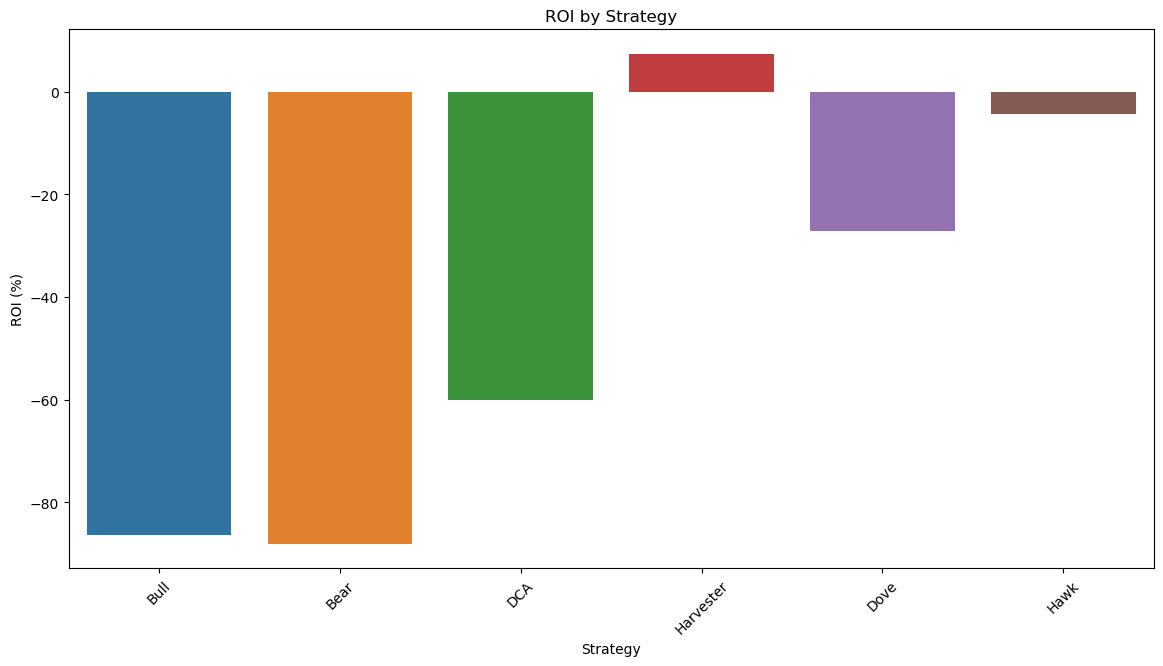

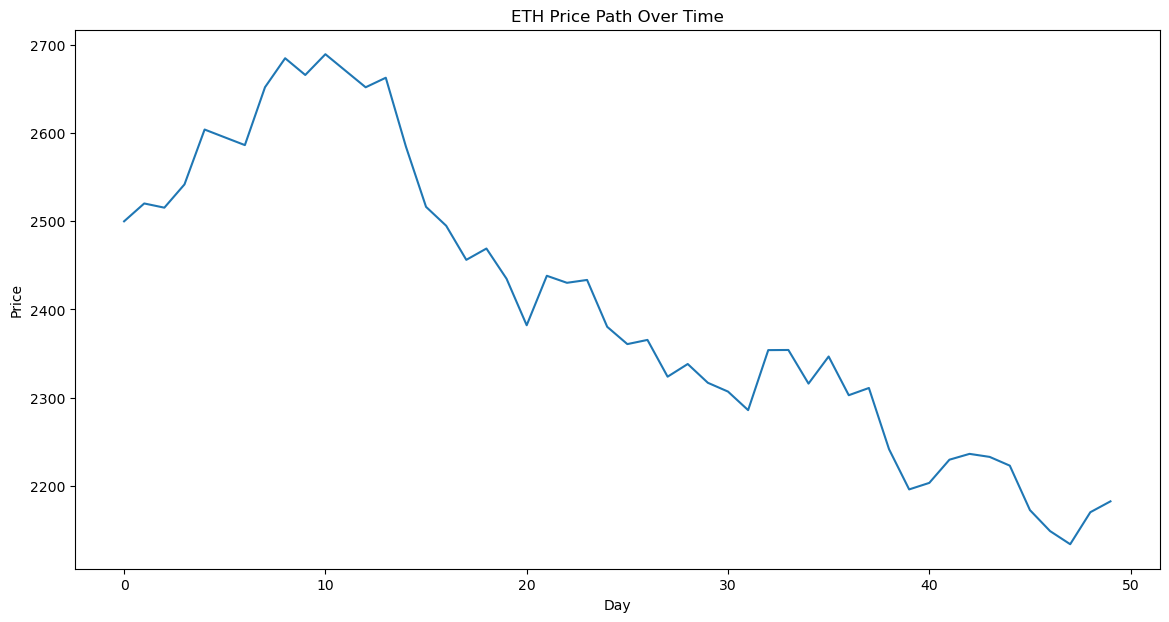

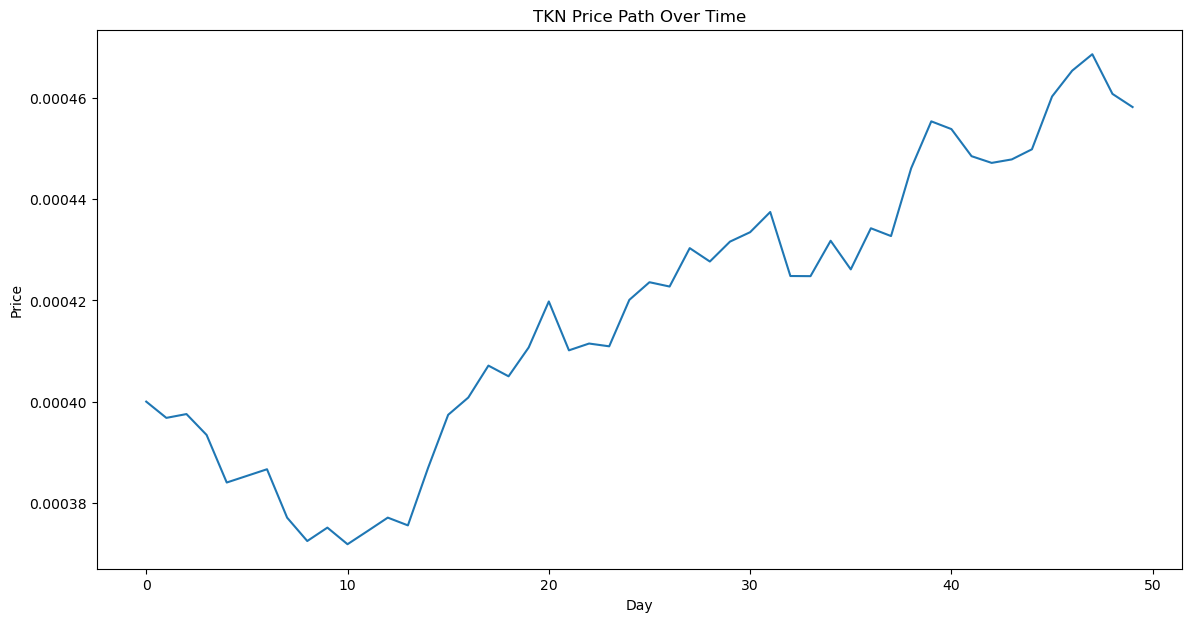

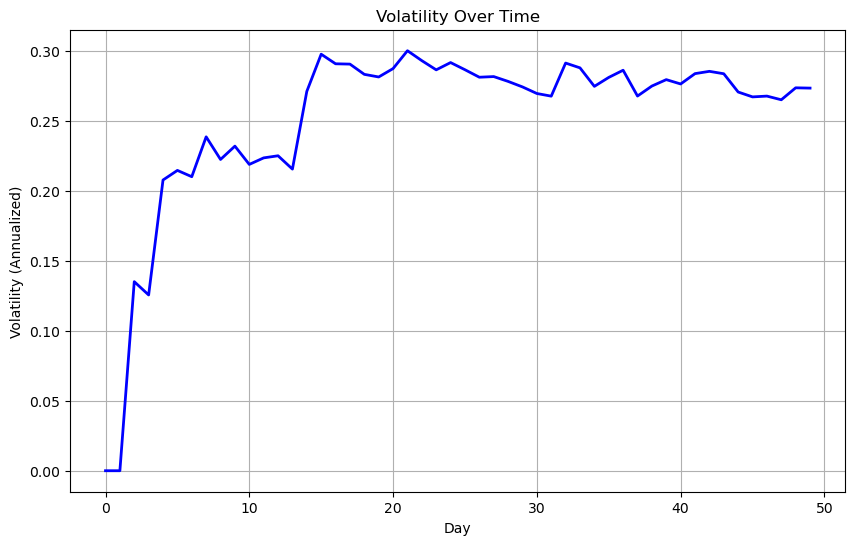

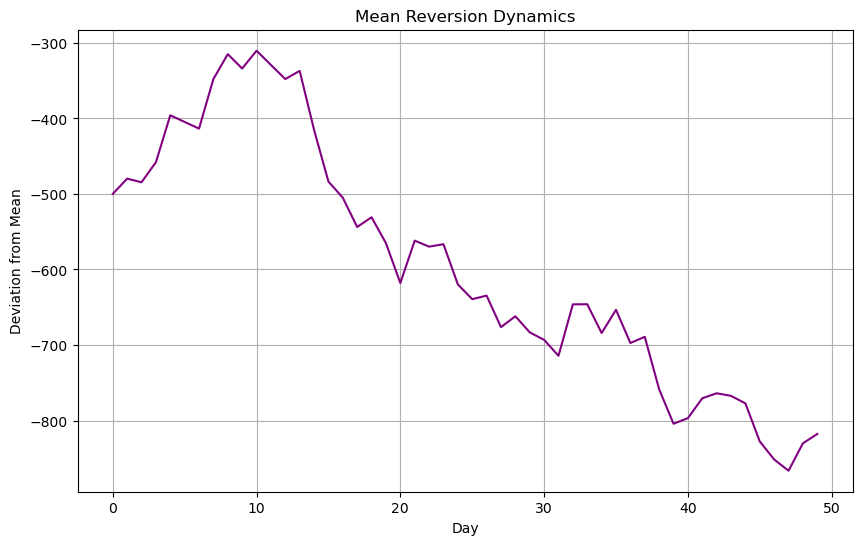

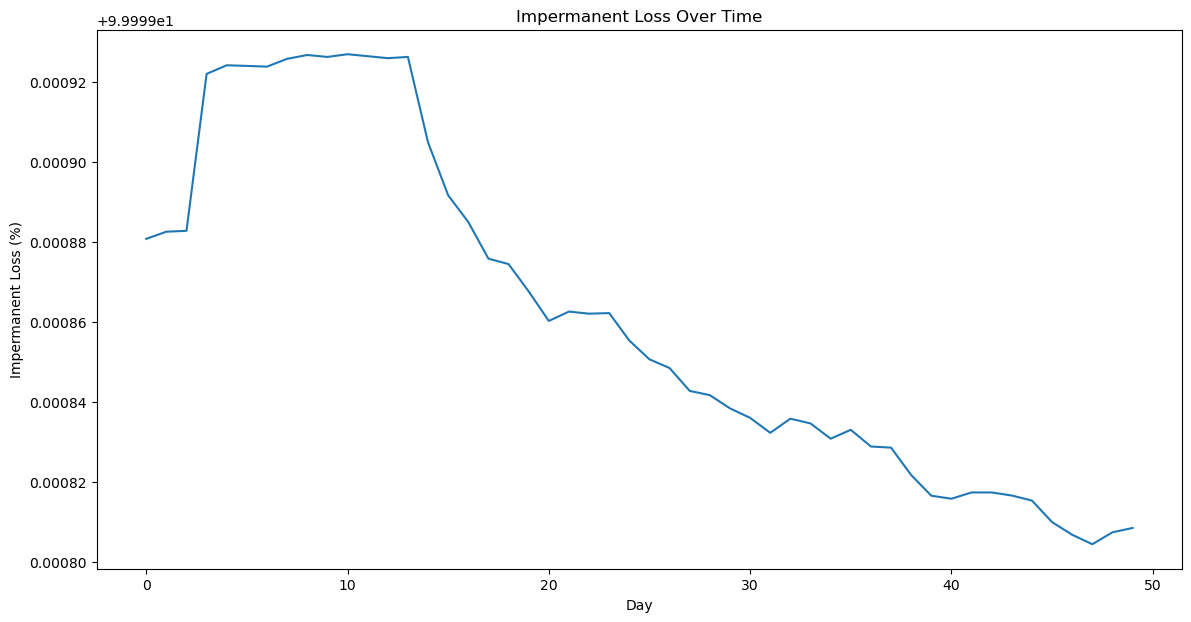

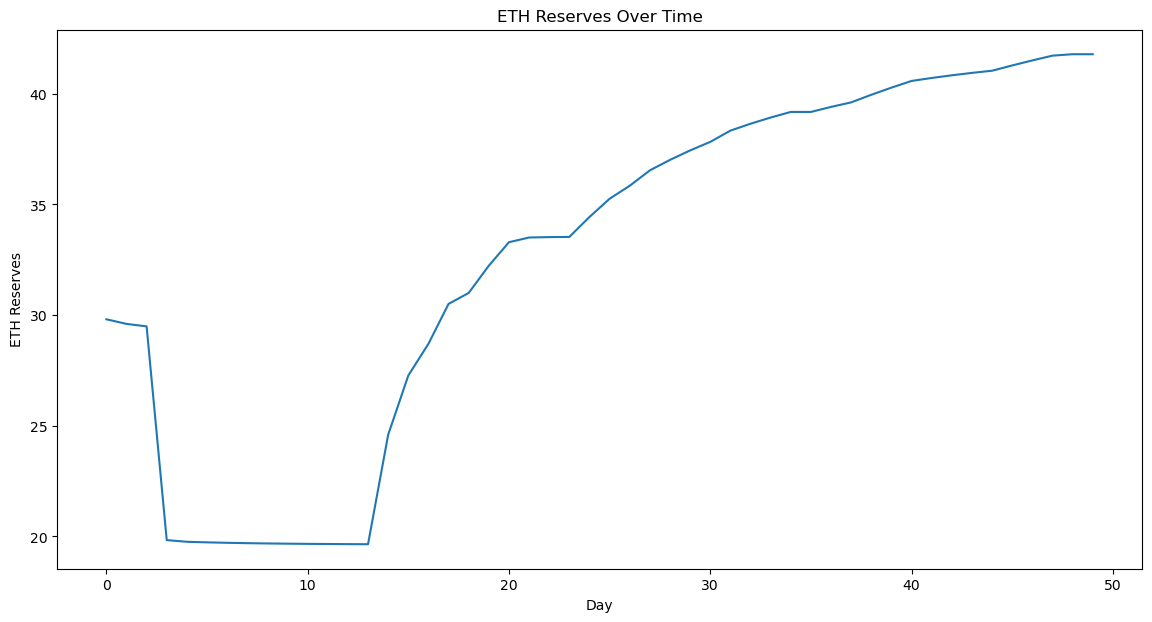

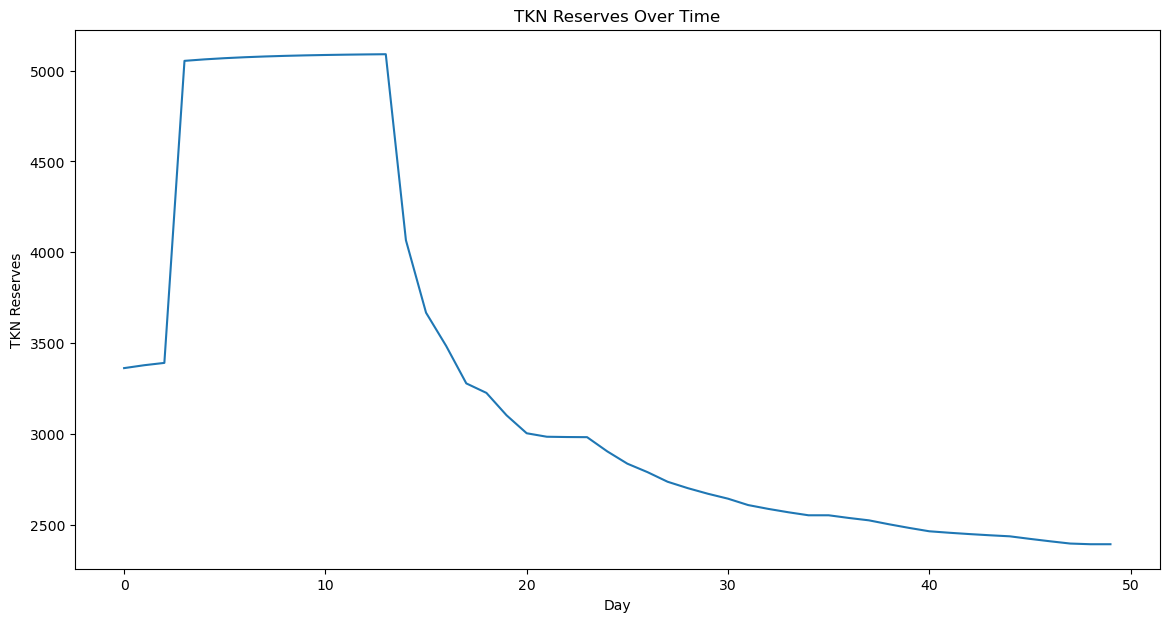

C:\Users\merca\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


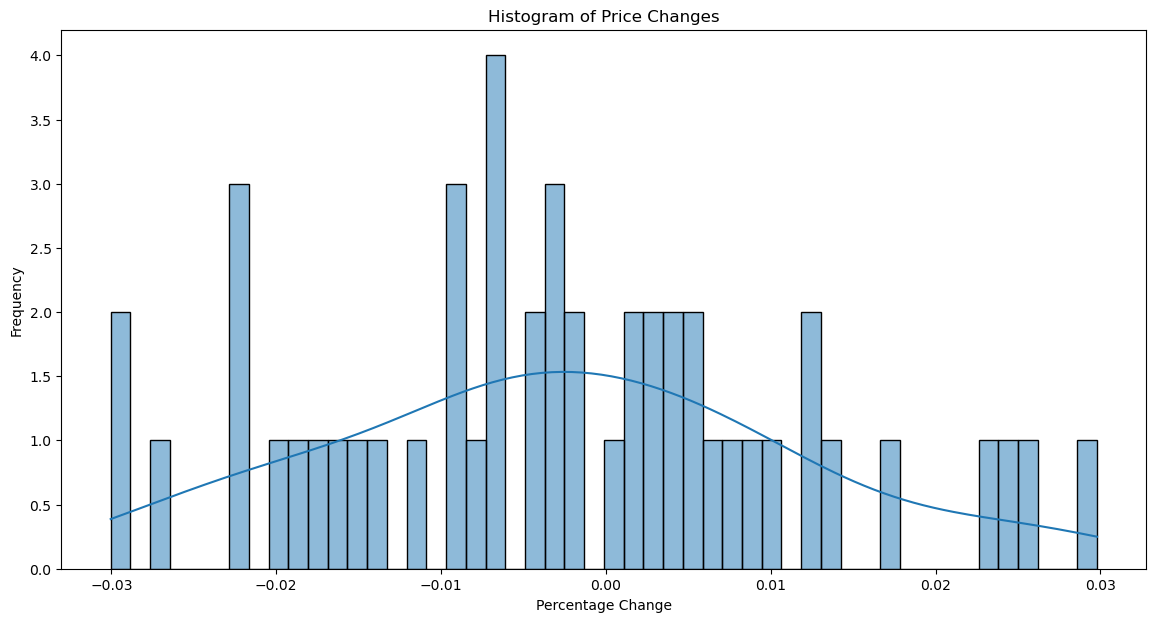

C:\Users\merca\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


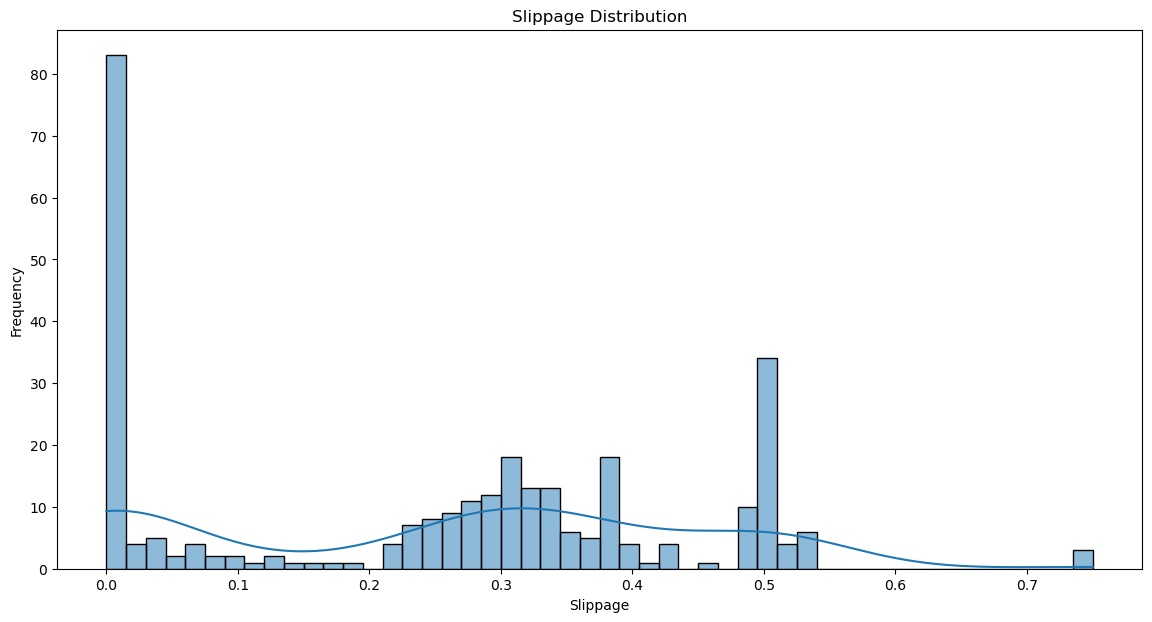

C:\Users\merca\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


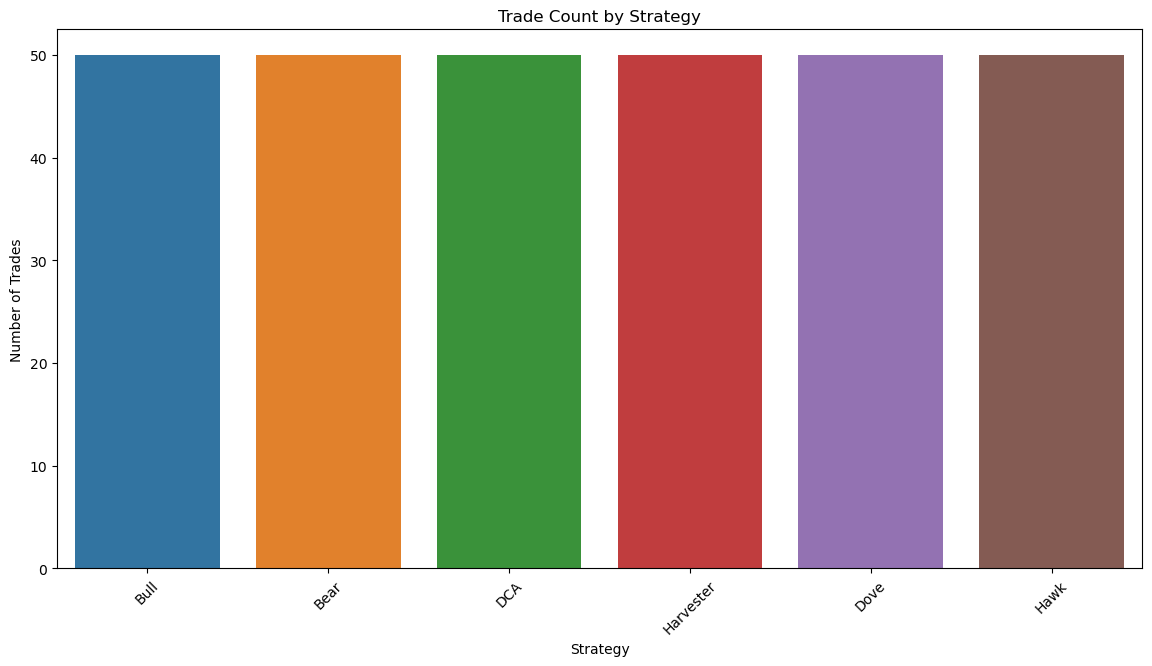

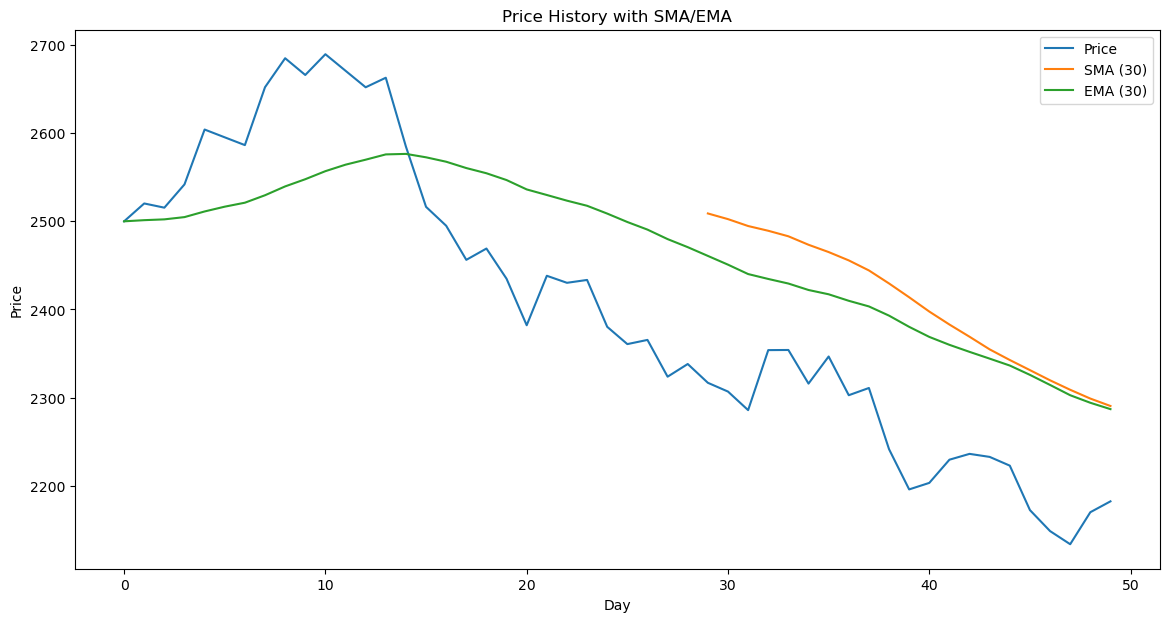

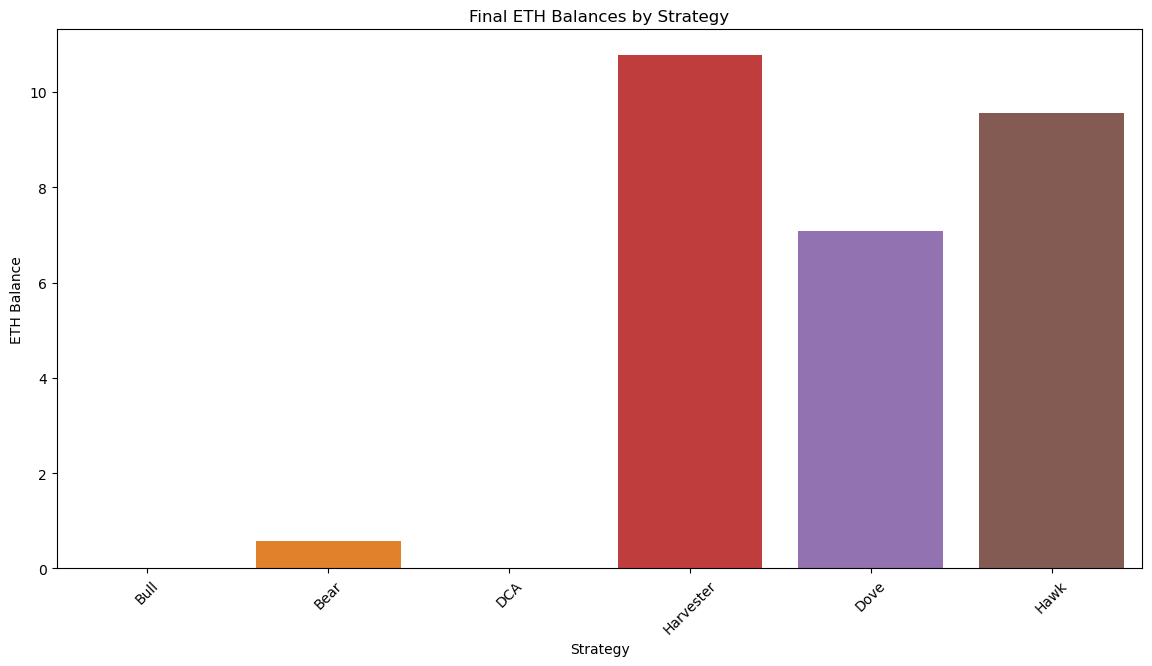

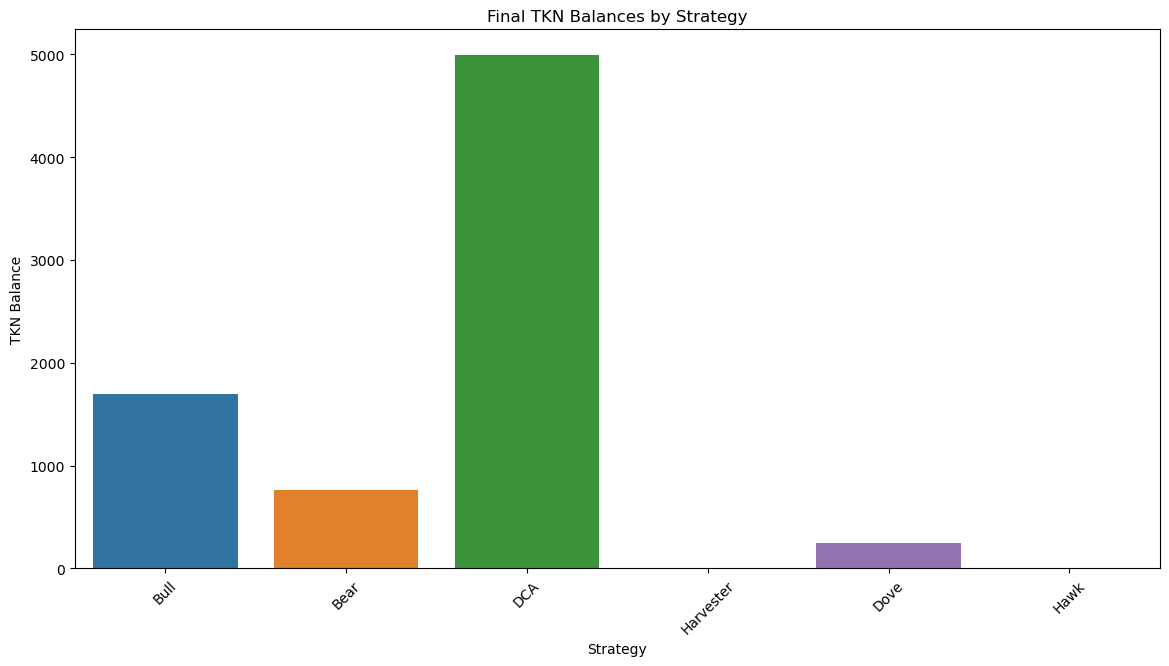

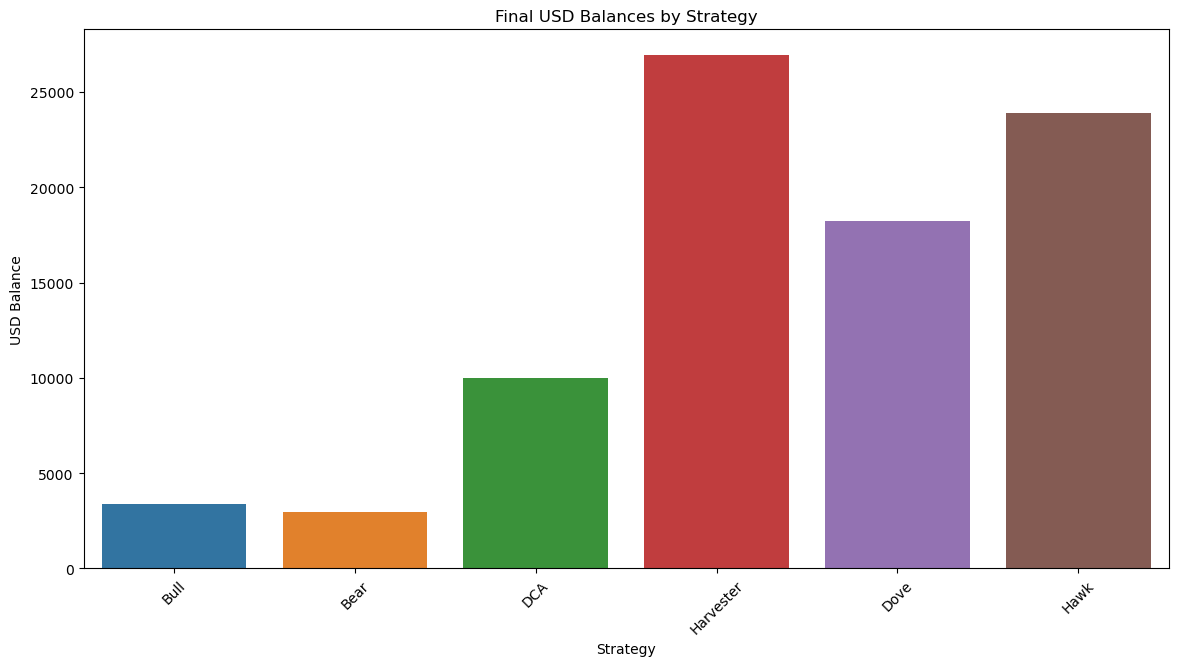

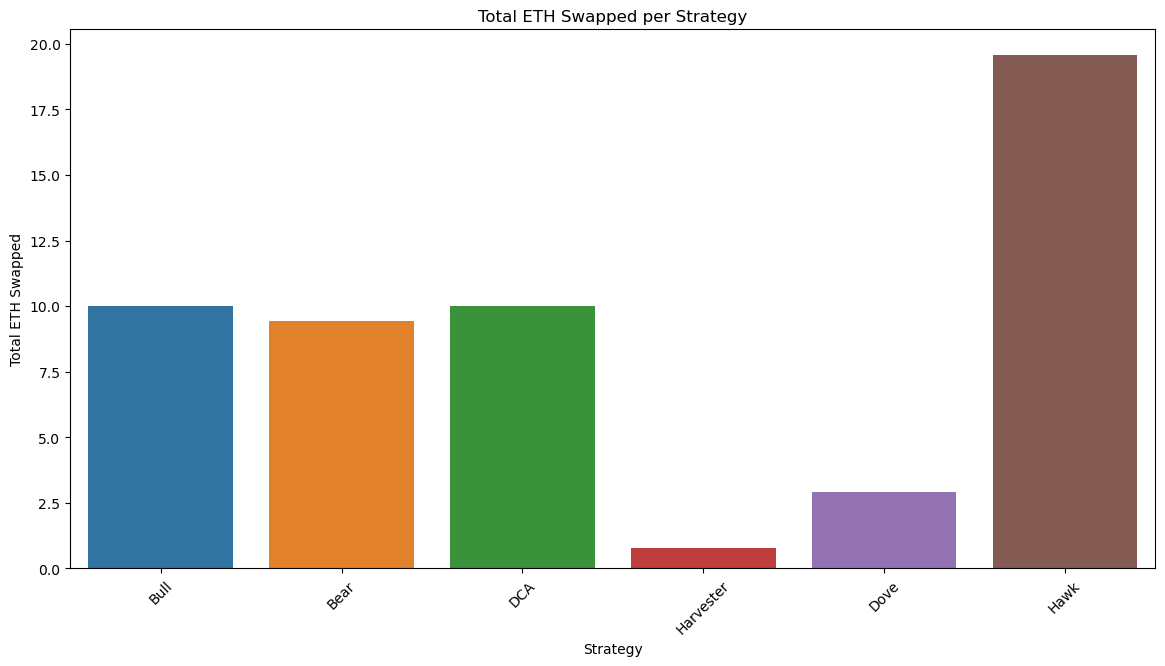

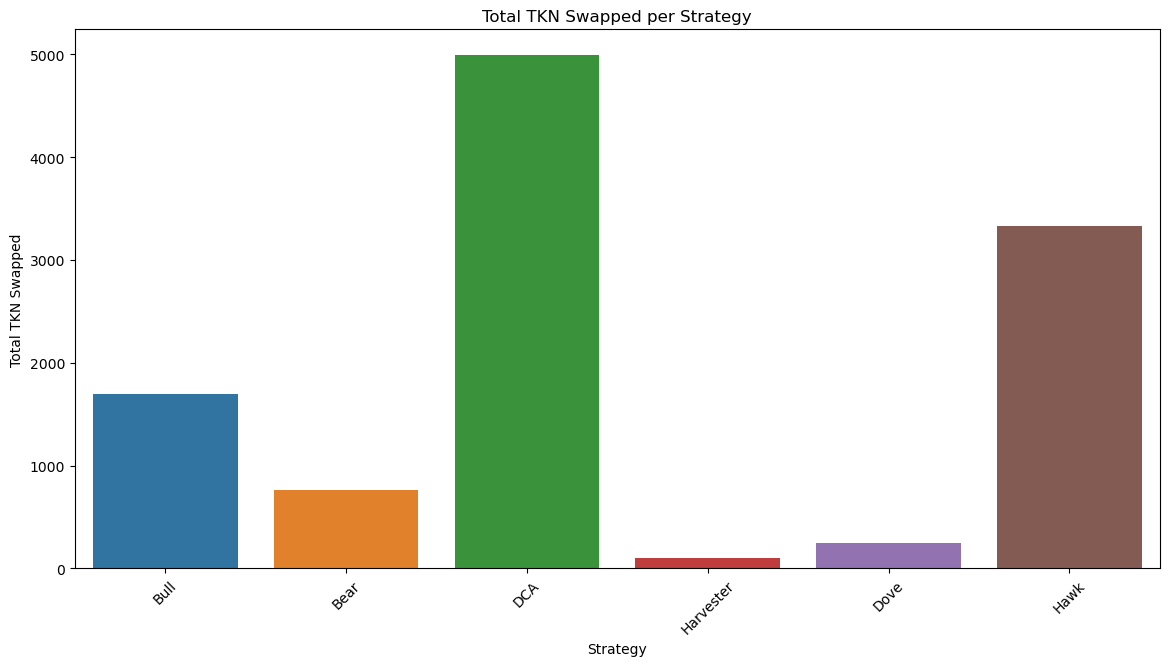

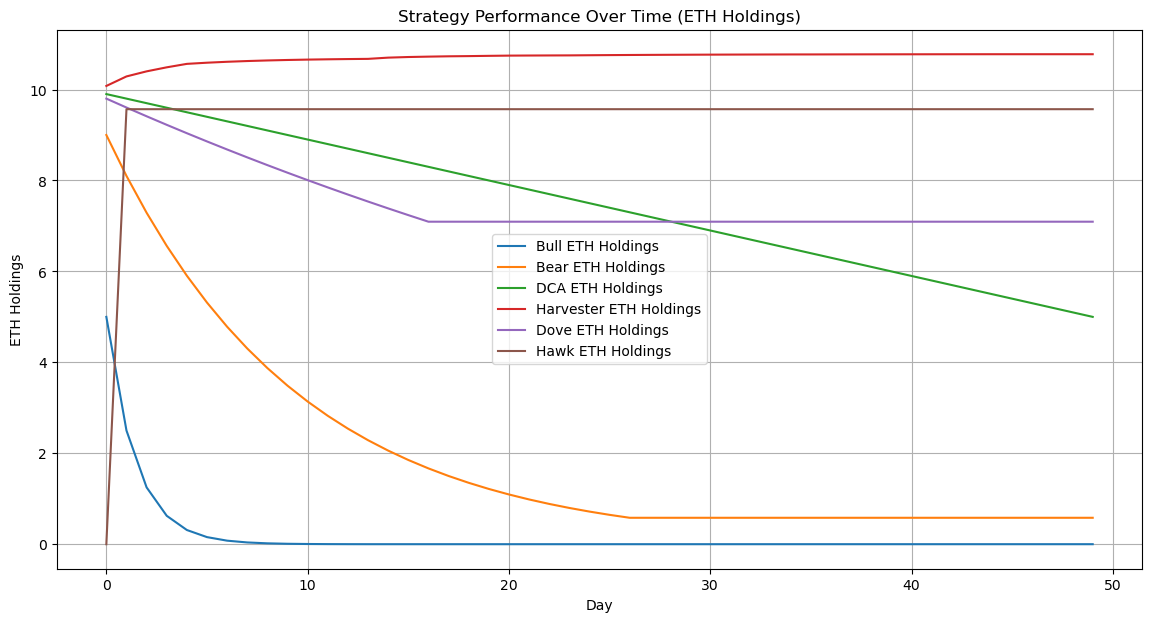

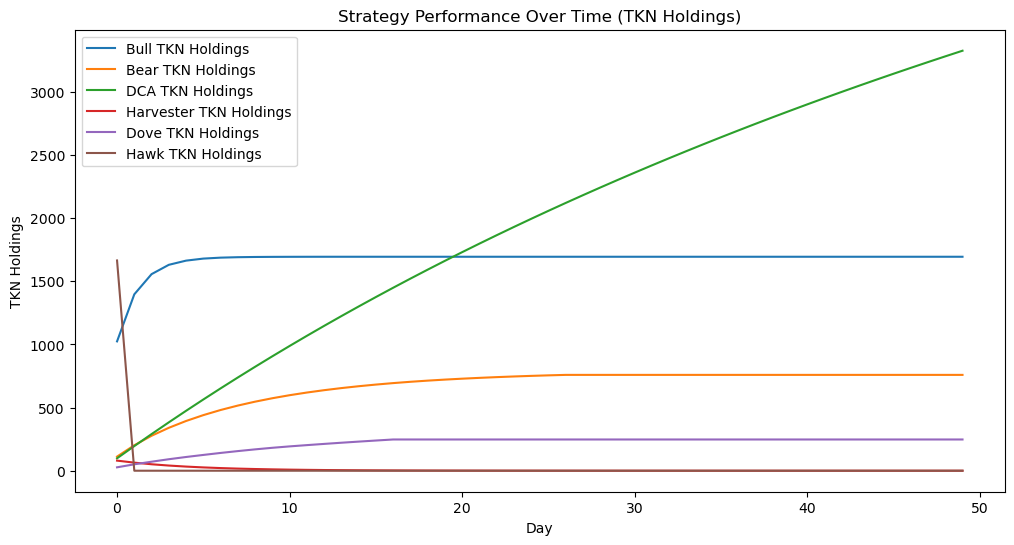

In [52]:
def main():
    market_conditions = load_json('bull_market.json')  # Load the correct JSON configuration file
    days = market_conditions['simulation_parameters']['days_of_simulation']
    initial_eth = market_conditions['simulation_parameters']['initial_pool_eth']
    initial_tkn = market_conditions['simulation_parameters']['initial_pool_tkn']
    
    # Get the initial ETH and TKN prices from the correct section
    initial_eth_price = market_conditions['market_conditions']['initial_eth_price']
    initial_tkn_price = 1  # Assuming initial TKN price is set to 1 as it's not in the JSON
    
    pool = TradingPool(initial_eth, initial_tkn)

    strategies = [
        BullStrategy("Bull", 10, 0, initial_eth_price, initial_tkn_price),
        BearStrategy("Bear", 10, 0, initial_eth_price, initial_tkn_price),
        DcaStrategy("DCA", 10, 0, initial_eth_price, initial_tkn_price, daily_investment=0.1),
        HarvesterStrategy("Harvester", 10, 100, initial_eth_price, initial_tkn_price),
        DoveStrategy("Dove", 10, 0, initial_eth_price, initial_tkn_price),
        HawkStrategy("Hawk", 10, 0, initial_eth_price, initial_tkn_price, target_profit=0.01),
    ]

    # Initialize trade summary dictionary
    trade_summary = {}

    # Run the simulation
    eth_price_history, tkn_price_history, trade_counts, eth_reserves_over_time, tkn_reserves_over_time, lp_fees_over_time, \
    impermanent_losses, price_impacts, detailed_logs = run_simulation(strategies, pool, market_conditions, days)

    # Evaluate the results
    results = evaluate_simulation(strategies)

    # Update trade summary with actual volumes
    for strategy in strategies:
        update_total_volume_swapped(trade_summary, strategy.name, strategy.participant)

    # Generate a summary of trades made by each strategy
    trade_summary = summarize_trades(strategies)

    # Create various tables to summarize the simulation results
    price_history_table = create_price_history_table(eth_price_history)
    volatility_table = create_volatility_tracking_table(eth_price_history)  # Create the volatility table here
    mean_reversion_table = create_mean_reversion_table(eth_price_history, mean_reversion_level=3000)
    final_balances_table = create_corrected_final_balances_table(strategies, eth_price_history)  # Pass eth_price_history
    total_volume_swapped_table = create_total_volume_swapped_table(trade_summary)
    roi_per_strategy_table = create_roi_per_strategy_table(results)
    impermanent_loss_table = create_impermanent_loss_table(impermanent_losses)
    total_lp_fees_table = create_total_lp_fees_table(lp_fees_over_time)

    # Print the first few rows of each table for inspection
    print("Price History Table")
    print(price_history_table.head())
    print("\nVolatility Tracking Table")
    print(volatility_table.head())
    print("\nMean Reversion Table")
    print(mean_reversion_table.head())
    print("\nFinal Balances Table")
    print(final_balances_table.head())
    print("\nTotal Volume Swapped Table")
    print(total_volume_swapped_table.head())
    print("\nROI per Strategy Table")
    print(roi_per_strategy_table.head())
    print("\nImpermanent Loss Table")
    print(impermanent_loss_table.head())
    print("\nTotal LP Fees Table")
    print(total_lp_fees_table.head())

    # Return all relevant data, including strategies and the volatility table
    return strategies, eth_price_history, tkn_price_history, final_balances_table, total_volume_swapped_table, results, price_impacts, trade_counts, eth_reserves_over_time, tkn_reserves_over_time, volatility_table, impermanent_losses

# Call main() and unpack the returned data
strategies, eth_price_history, tkn_price_history, final_balances_table, total_volume_swapped_table, results, price_impacts, trade_counts, eth_reserves_over_time, tkn_reserves_over_time, volatility_table, impermanent_losses = main()

# Generate and display the plots
plot_roi_by_strategy(results)
plot_price_path(eth_price_history)  # ETH price plot
plot_tkn_price_path(tkn_price_history)  # New TKN price plot
plot_volatility_over_time(volatility_table)  # Now volatility_table should be defined
plot_mean_reversion(eth_price_history, mean_reversion_level=3000)
plot_impermanent_loss_over_time(impermanent_losses)  # Now impermanent_losses should be defined
plot_eth_reserves_over_time(eth_reserves_over_time)
plot_tkn_reserves_over_time(tkn_reserves_over_time)

# Additional Visualizations
plot_histogram_of_price_changes(eth_price_history)
plot_slippage_distribution(price_impacts)
plot_trade_count_by_strategy(trade_counts)
plot_price_history_with_sma_ema(eth_price_history)

# Added Visualizations
plot_final_eth_balances_by_strategy(final_balances_table)
plot_final_tkn_balances_by_strategy(final_balances_table)
plot_final_usd_balances_by_strategy(final_balances_table)
plot_total_eth_swapped_per_strategy(total_volume_swapped_table)
plot_total_tkn_swapped_per_strategy(total_volume_swapped_table)
plot_strategy_performance_over_time(strategies, eth_price_history)


In [53]:
def run_simulation_and_prepare_data():
    market_conditions = load_json('bull_market.json')
    days = market_conditions['simulation_parameters']['days_of_simulation']
    initial_eth = market_conditions['simulation_parameters']['initial_pool_eth']
    initial_tkn = market_conditions['simulation_parameters']['initial_pool_tkn']
    initial_eth_price = market_conditions['market_conditions']['initial_eth_price']
    initial_tkn_price = 1  # Assuming initial TKN price is set to 1 as it's not in the JSON
    
    pool = TradingPool(initial_eth, initial_tkn)

    strategies = [
        BullStrategy("Bull", 10, 0, initial_eth_price, initial_tkn_price),
        BearStrategy("Bear", 10, 0, initial_eth_price, initial_tkn_price),
        DcaStrategy("DCA", 10, 0, initial_eth_price, initial_tkn_price, daily_investment=0.1),
        HarvesterStrategy("Harvester", 10, 100, initial_eth_price, initial_tkn_price),
        DoveStrategy("Dove", 10, 0, initial_eth_price, initial_tkn_price),
        HawkStrategy("Hawk", 10, 0, initial_eth_price, initial_tkn_price, target_profit=0.05),
    ]

    # Initialize trade summary dictionary
    trade_summary = {}

    # Run the simulation
    eth_price_history, tkn_price_history, trade_counts, eth_reserves_over_time, tkn_reserves_over_time, \
    lp_fees_over_time, impermanent_losses, price_impacts, detailed_logs = run_simulation(strategies, pool, market_conditions, days)

    # Evaluate the results
    results = evaluate_simulation(strategies)

    # Update trade summary with actual volumes
    for strategy in strategies:
        update_total_volume_swapped(trade_summary, strategy.name, strategy.participant)

    # Generate a summary of trades made by each strategy
    trade_summary = summarize_trades(strategies)

    # Create various tables to summarize the simulation results
    price_history_table = create_price_history_table(eth_price_history)
    volatility_table = create_volatility_tracking_table(eth_price_history)
    mean_reversion_table = create_mean_reversion_table(eth_price_history, mean_reversion_level=3000)
    final_balances_table = create_corrected_final_balances_table(strategies, eth_price_history)
    total_volume_swapped_table = create_total_volume_swapped_table(trade_summary)
    roi_per_strategy_table = create_roi_per_strategy_table(results)
    impermanent_loss_table = create_impermanent_loss_table(impermanent_losses)
    total_lp_fees_table = create_total_lp_fees_table(lp_fees_over_time)

    return {
        "price_history_table": price_history_table,
        "volatility_table": volatility_table,
        "mean_reversion_table": mean_reversion_table,
        "final_balances_table": final_balances_table,
        "total_volume_swapped_table": total_volume_swapped_table,
        "roi_per_strategy_table": roi_per_strategy_table,
        "impermanent_loss_table": impermanent_loss_table,
        "total_lp_fees_table": total_lp_fees_table,
        "eth_price_history": eth_price_history,  # Note this change from 'price_history' to 'eth_price_history'
        "tkn_price_history": tkn_price_history,
        "results": results,
        "eth_reserves_over_time": eth_reserves_over_time,
        "tkn_reserves_over_time": tkn_reserves_over_time,
        "impermanent_losses": impermanent_losses,
        "price_impacts": price_impacts,
        "trade_counts": trade_counts,
        "strategies": strategies,
    }

# Run the simulation and store the results
simulation_data = run_simulation_and_prepare_data()


Bull Post-Execution ETH Balance: 10, TKN Balance: 0
Bear Post-Execution ETH Balance: 10, TKN Balance: 0
DCA Post-Execution ETH Balance: 0.0, TKN Balance: 4992.313915535055
Harvester: Selling 20.0 TKN at price 2500
Harvester: Updated TKN balance is 80.0
Harvester Post-Execution ETH Balance: 10.078960121469235, TKN Balance: 80.0
Dove Post-Execution ETH Balance: 10, TKN Balance: 0
Hawk Post-Execution ETH Balance: 0, TKN Balance: 1665.2261139495683
Bull Post-Execution ETH Balance: 10, TKN Balance: 0
Bear: Updated TKN balance is 0
Bear Post-Execution ETH Balance: 10, TKN Balance: 0
DCA Post-Execution ETH Balance: 0.0, TKN Balance: 4992.313915535055
Harvester: Selling 16.0 TKN at price 2513.4434453823783
Harvester: Updated TKN balance is 64.0
Harvester Post-Execution ETH Balance: 10.28815025352171, TKN Balance: 64.0
Dove Post-Execution ETH Balance: 10, TKN Balance: 0
Hawk Post-Execution ETH Balance: 0, TKN Balance: 1665.2261139495683
Bull: Actively buying TKN with 5.0 ETH at price 2498.97547

In [54]:
# Display the Price History Table
display(simulation_data['price_history_table'].head())


,Day,Price
0,0,2500.000000
1,1,2513.443445
2,2,2498.975475
3,3,2473.230759
4,4,2497.784772


In [55]:
# Display the Volatility Tracking Table
display(simulation_data['volatility_table'].head())


,Day,Volatility
0,0,0.000000
1,1,0.000000
2,2,0.150407
3,3,0.154122
4,4,0.180103


In [56]:
# Display the Mean Reversion Table
display(simulation_data['mean_reversion_table'].head())


,Day,Price,Deviation_from_Mean
0,0,2500.000000,-500.000000
1,1,2513.443445,-486.556555
2,2,2498.975475,-501.024525
3,3,2473.230759,-526.769241
4,4,2497.784772,-502.215228


In [57]:
# Display the Final Balances Table
display(simulation_data['final_balances_table'].head())


,Strategy,Final_ETH_Balance,Final_TKN_Balance,Final_USD_Balance,ROI,Sharpe_Ratio
0,Bull,0.167790,1580.216826,3579.908366,-85.680367,0.043164
1,Bear,10.000000,0.000000,25000.000000,0.000000,0.043218
2,DCA,0.000000,4992.313916,9984.627831,-60.061489,-0.049172
3,Harvester,11.196082,0.004356,27990.212911,11.514792,0.043218
4,Dove,10.000000,0.000000,25000.000000,0.000000,0.043218


In [58]:
# Display the Total Volume Swapped Table
display(simulation_data['total_volume_swapped_table'].head())


,ETH Swapped,TKN Swapped
Strategy,,
Bull,47.976192,5728.399189
Bear,0.000000,0.000000
DCA,10.000000,4992.313916
Harvester,1.196082,99.995644
Dove,0.000000,0.000000


In [59]:
# Display the ROI per Strategy Table
display(simulation_data['roi_per_strategy_table'].head())


,Strategy,ROI
0,Bull,-85.680367
1,Bear,0.000000
2,DCA,-60.061489
3,Harvester,11.514792
4,Dove,0.000000


In [60]:
# Display the Impermanent Loss Table
display(simulation_data['impermanent_loss_table'].head())


,Day,Impermanent_Loss
0,0,99.999881
1,1,99.999882
2,2,99.999862
3,3,99.999851
4,4,99.999853


In [61]:
# Display the Total LP Fees Table
display(simulation_data['total_lp_fees_table'].head())

,ETH_Fees,TKN_Fees
Day,,
0,0.110972,0.060799
1,0.110972,0.109560
2,0.134418,0.148526
3,0.143734,0.179633
4,0.143734,0.204456


C:\Users\merca\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


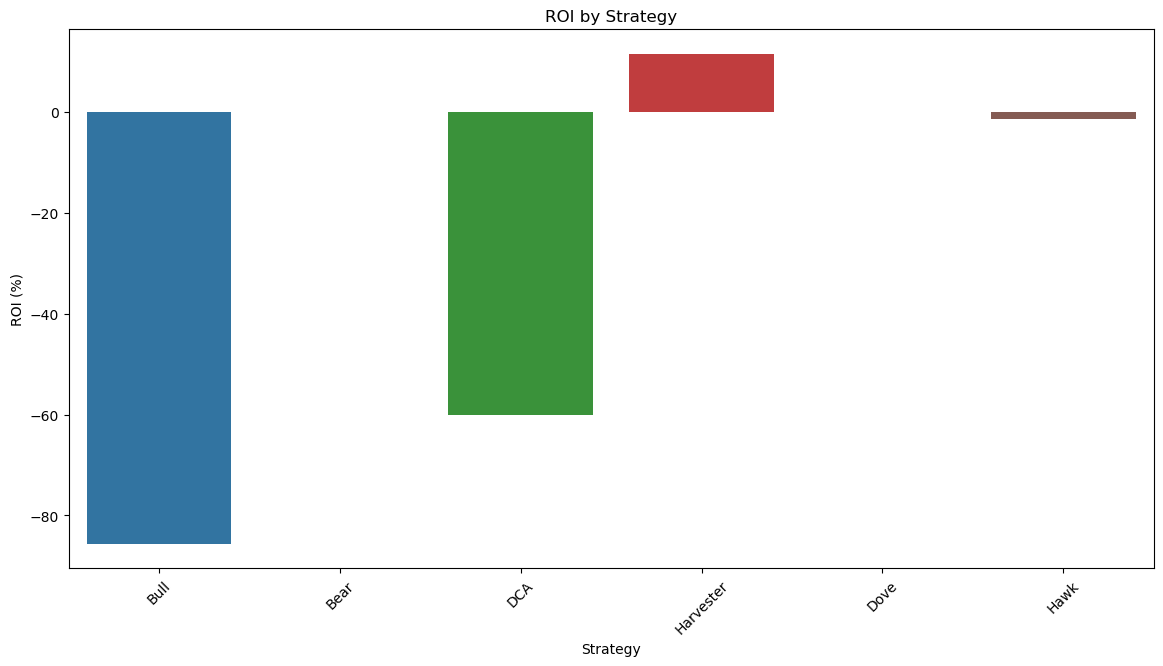

In [62]:
# Plot ROI by Strategy
plot_roi_by_strategy(simulation_data['results'])


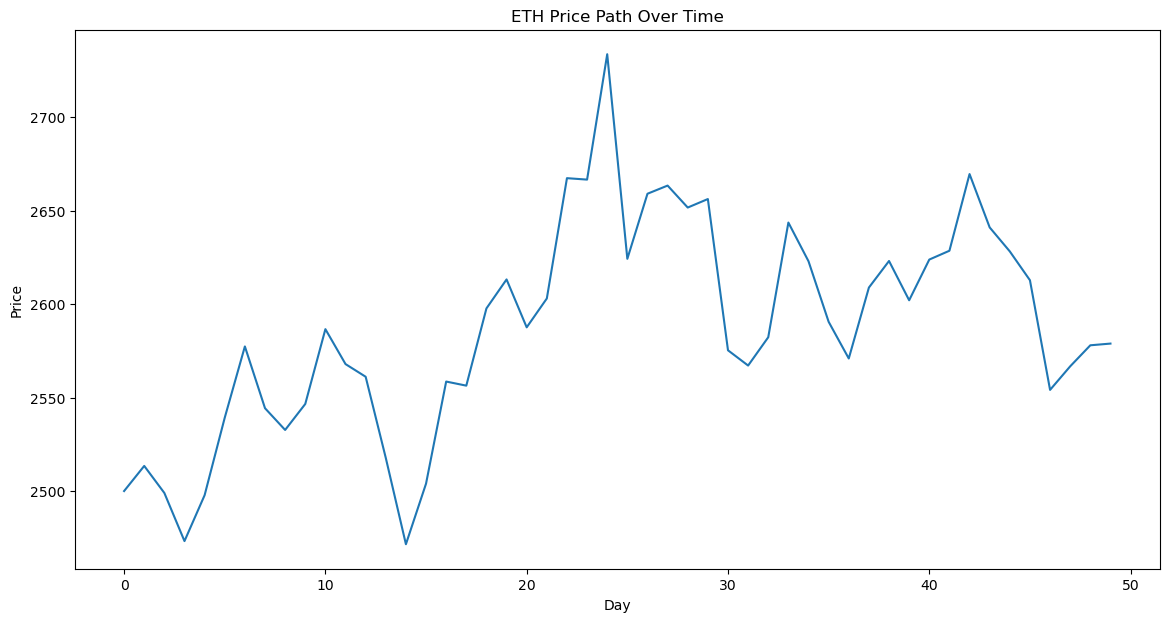

In [63]:
plot_price_path(simulation_data['eth_price_history'])


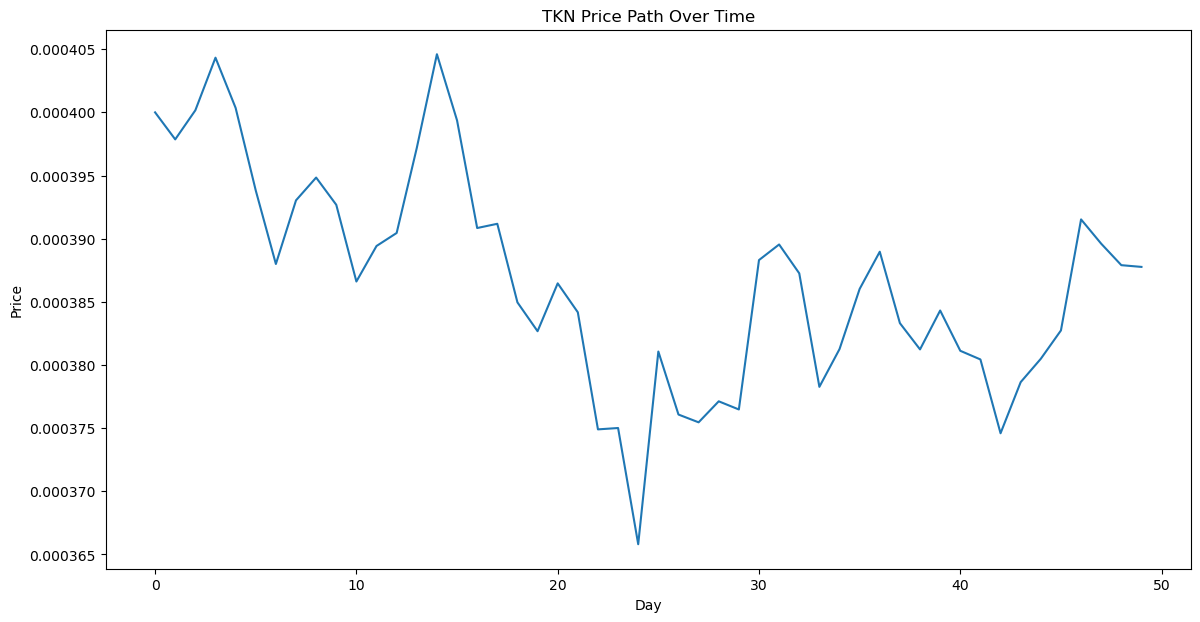

In [64]:
plot_tkn_price_path(simulation_data['tkn_price_history'])


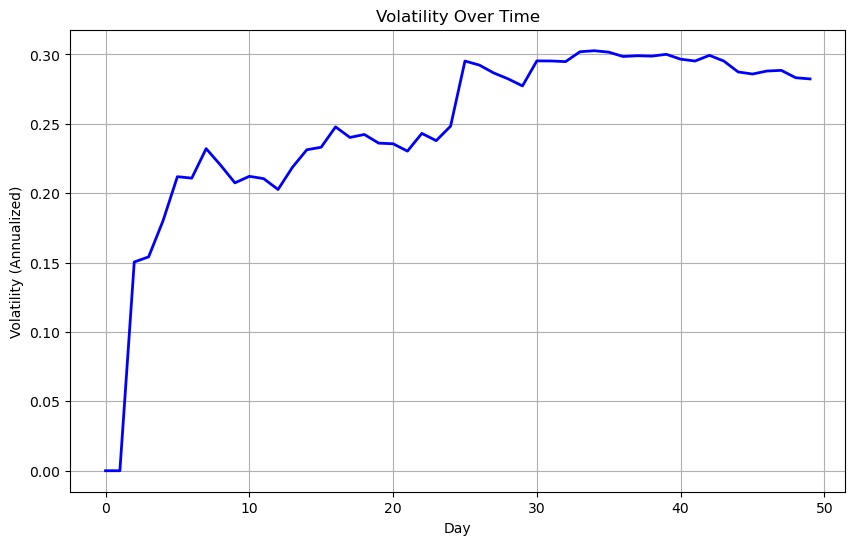

In [65]:
# Plot Volatility Over Time
plot_volatility_over_time(simulation_data['volatility_table'])


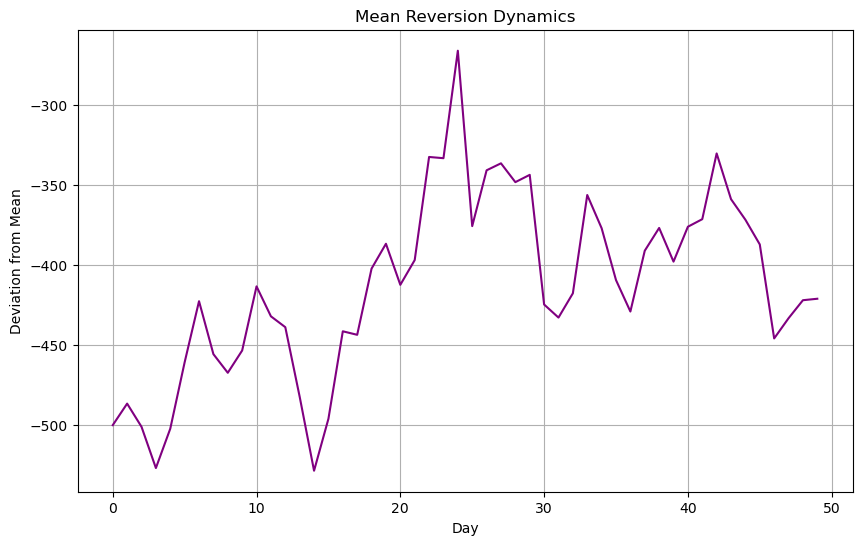

In [66]:
# Plot Mean Reversion Dynamics
plot_mean_reversion(simulation_data['eth_price_history'], mean_reversion_level=3000)


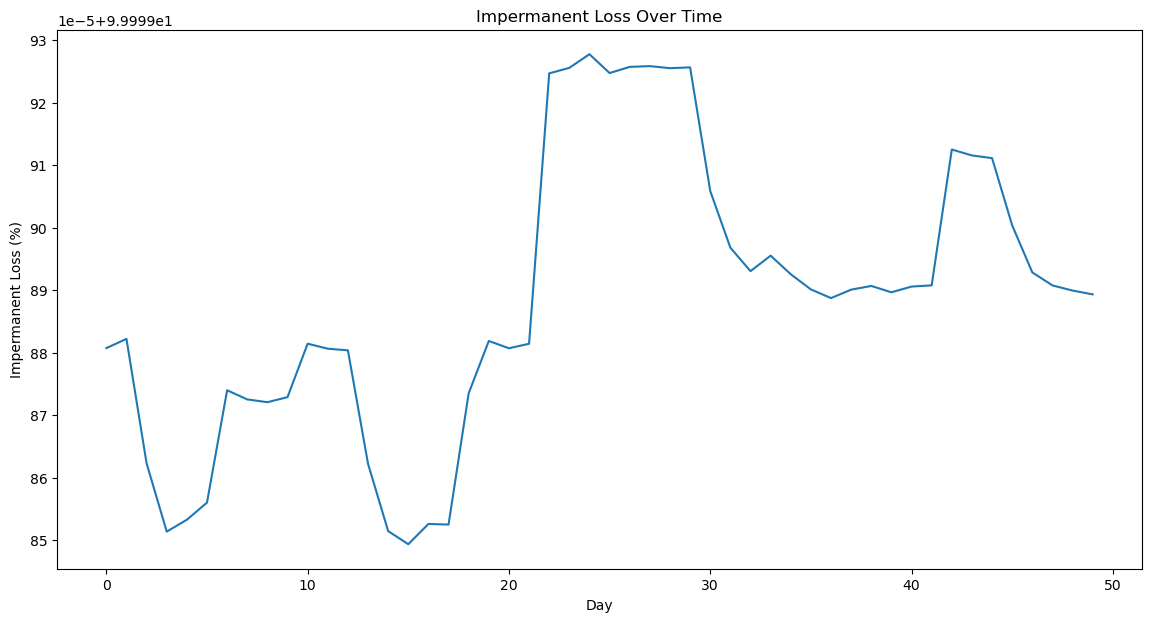

In [67]:
# Plot Impermanent Loss Over Time
plot_impermanent_loss_over_time(simulation_data['impermanent_losses'])


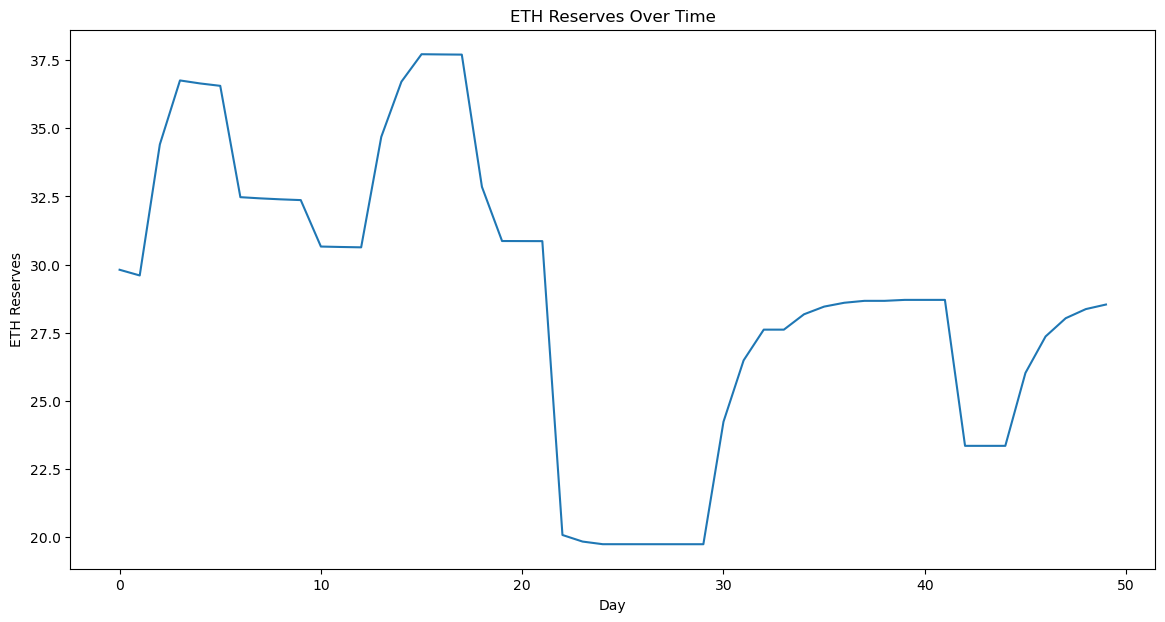

In [68]:
# Plot ETH Reserves Over Time
plot_eth_reserves_over_time(simulation_data['eth_reserves_over_time'])


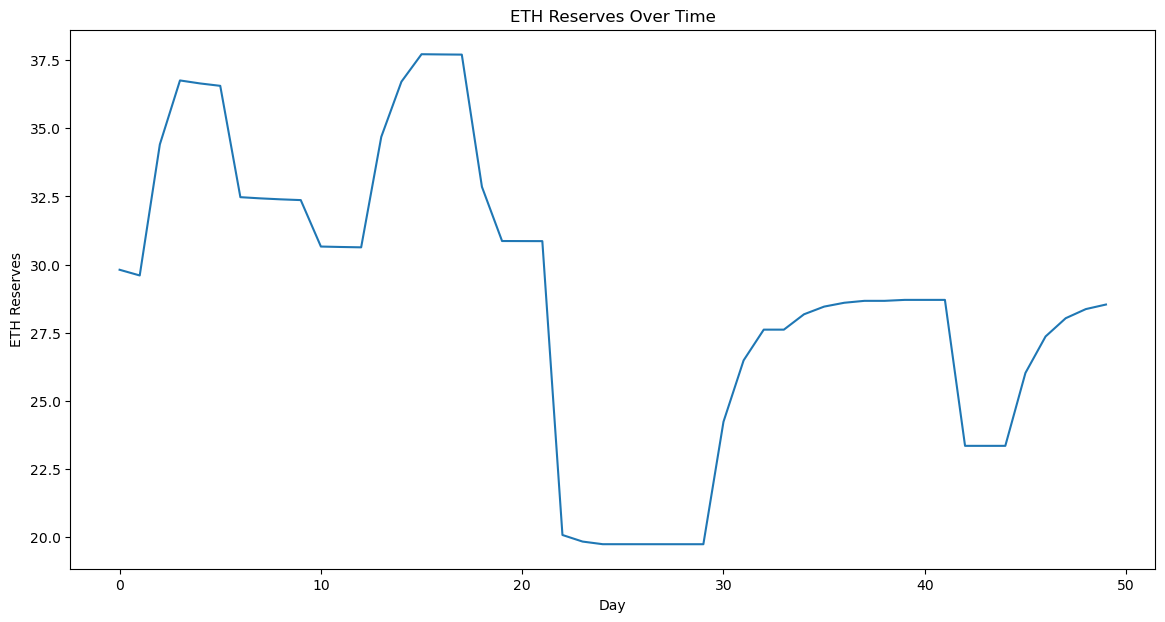

In [69]:
# Plot ETH Reserves Over Time
plot_eth_reserves_over_time(simulation_data['eth_reserves_over_time'])


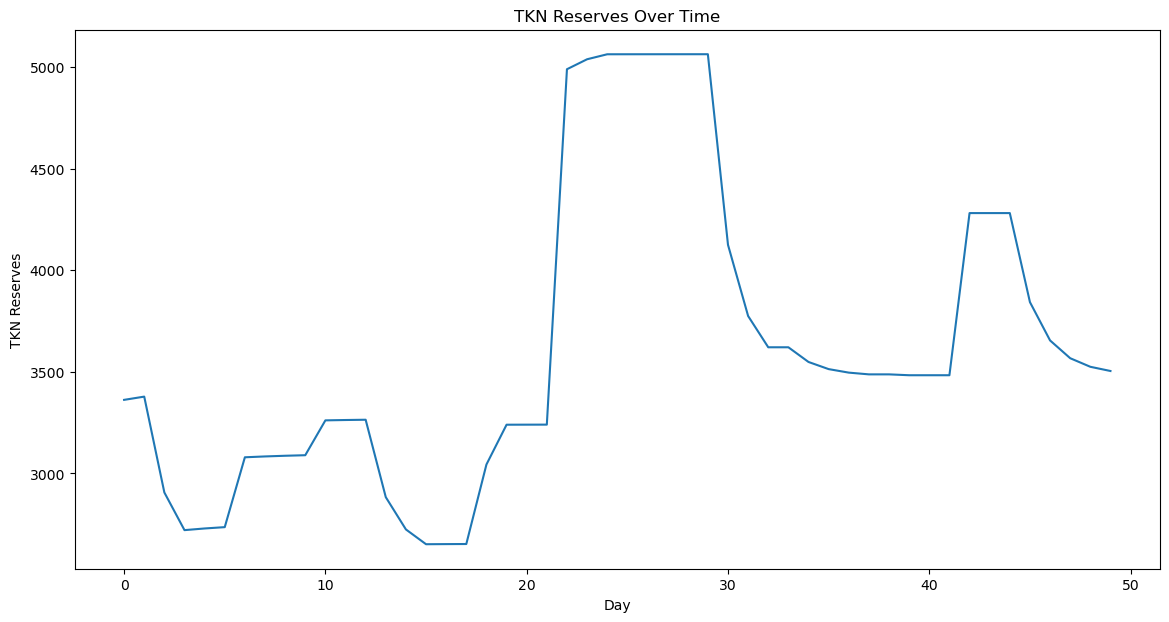

In [70]:
# Plot TKN Reserves Over Time
plot_tkn_reserves_over_time(simulation_data['tkn_reserves_over_time'])


C:\Users\merca\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


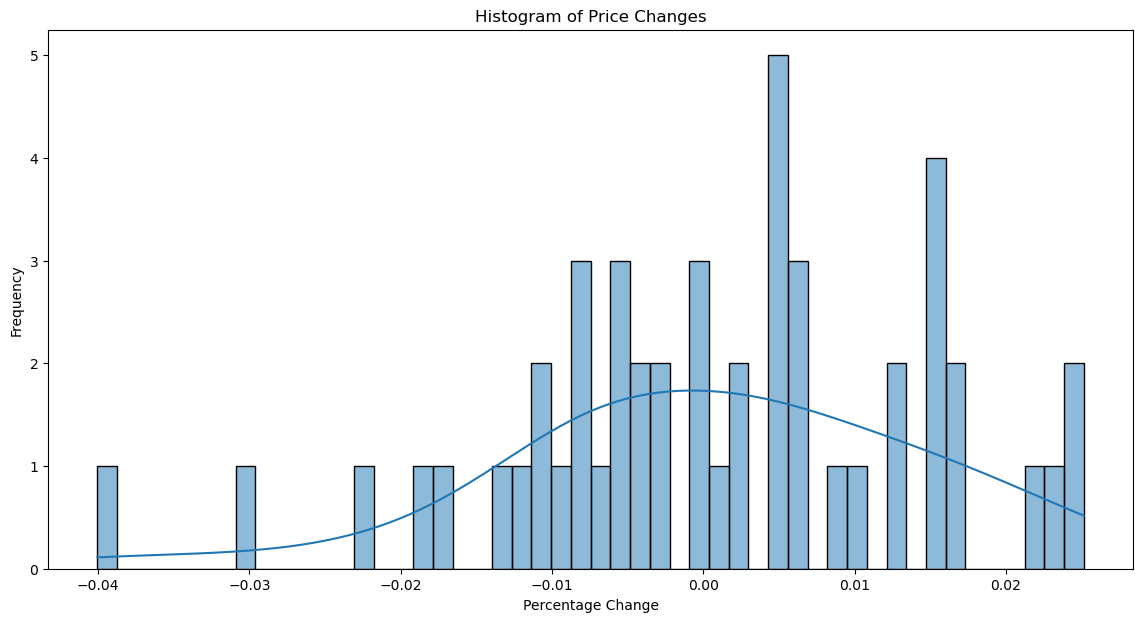

In [71]:
# Additional Visualizations
# Additional Visualizations
plot_histogram_of_price_changes(simulation_data['eth_price_history'])


C:\Users\merca\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


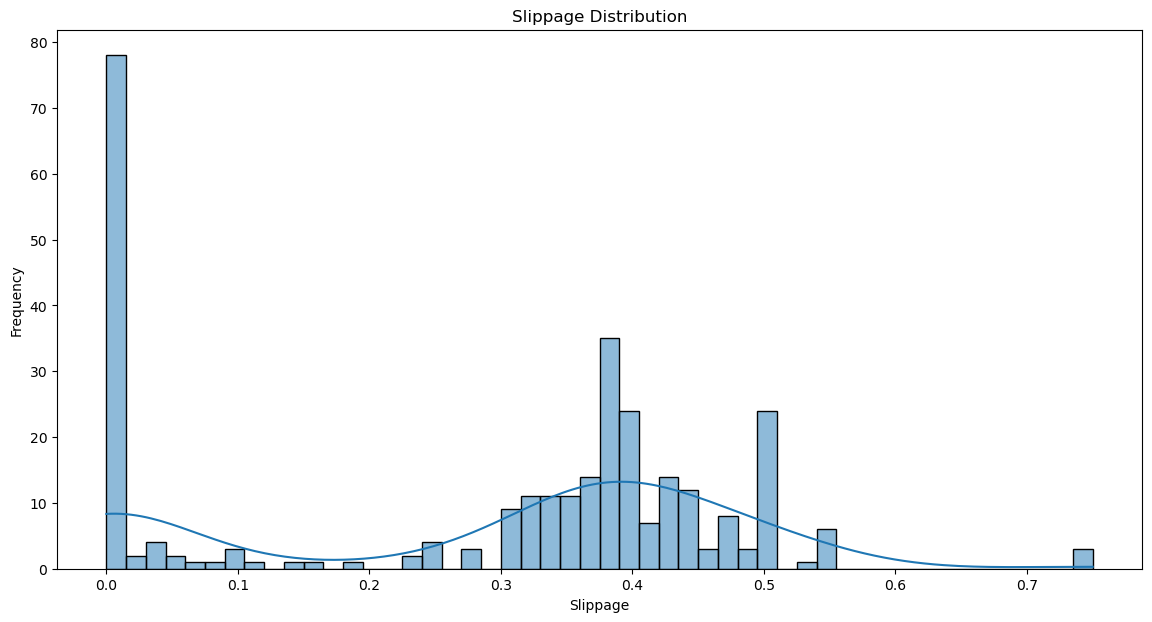

In [72]:
plot_slippage_distribution(simulation_data['price_impacts'])


C:\Users\merca\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


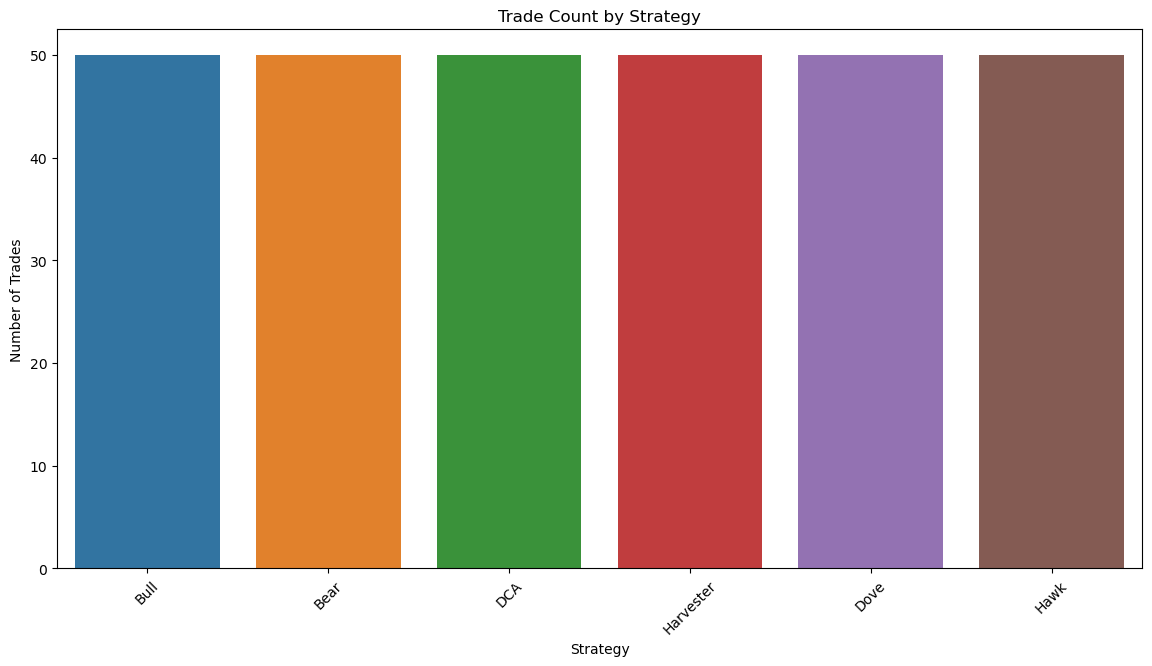

In [73]:
plot_trade_count_by_strategy(simulation_data['trade_counts'])


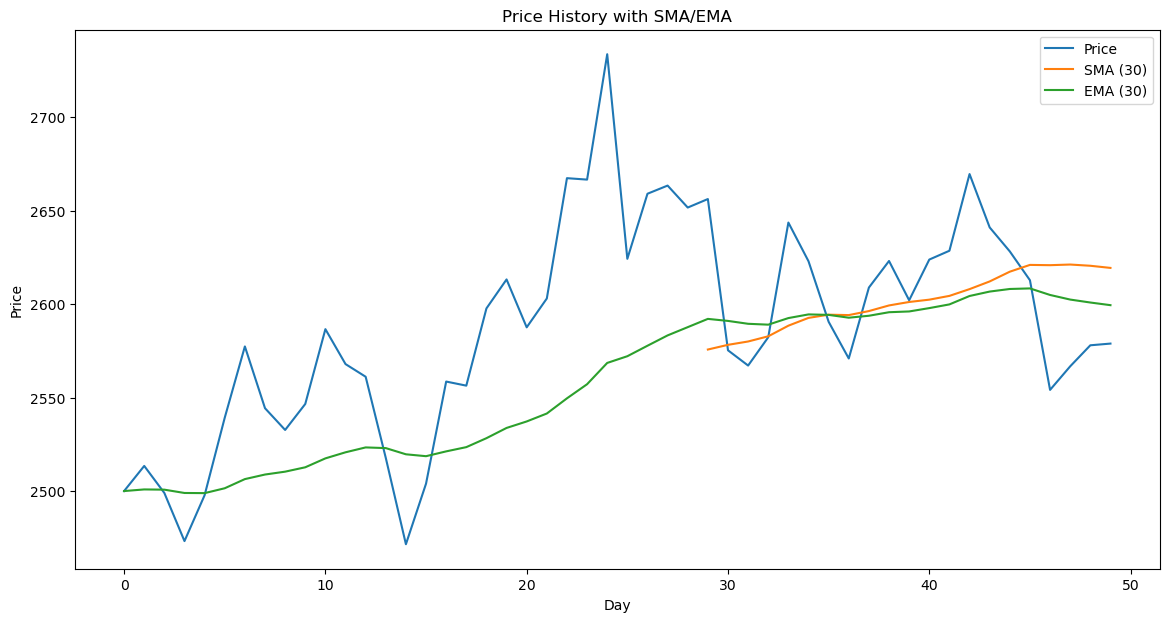

In [74]:
# Plot Price History with SMA and EMA
plot_price_history_with_sma_ema(simulation_data['eth_price_history'])


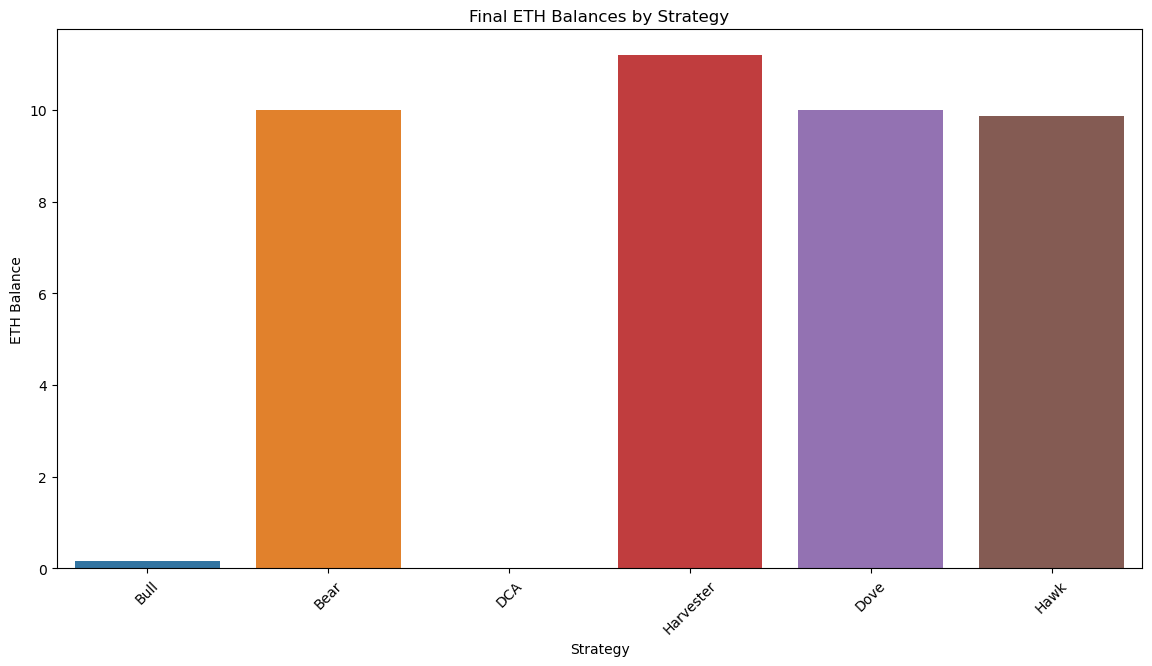

In [75]:
# Added Visualizations
plot_final_eth_balances_by_strategy(simulation_data['final_balances_table'])


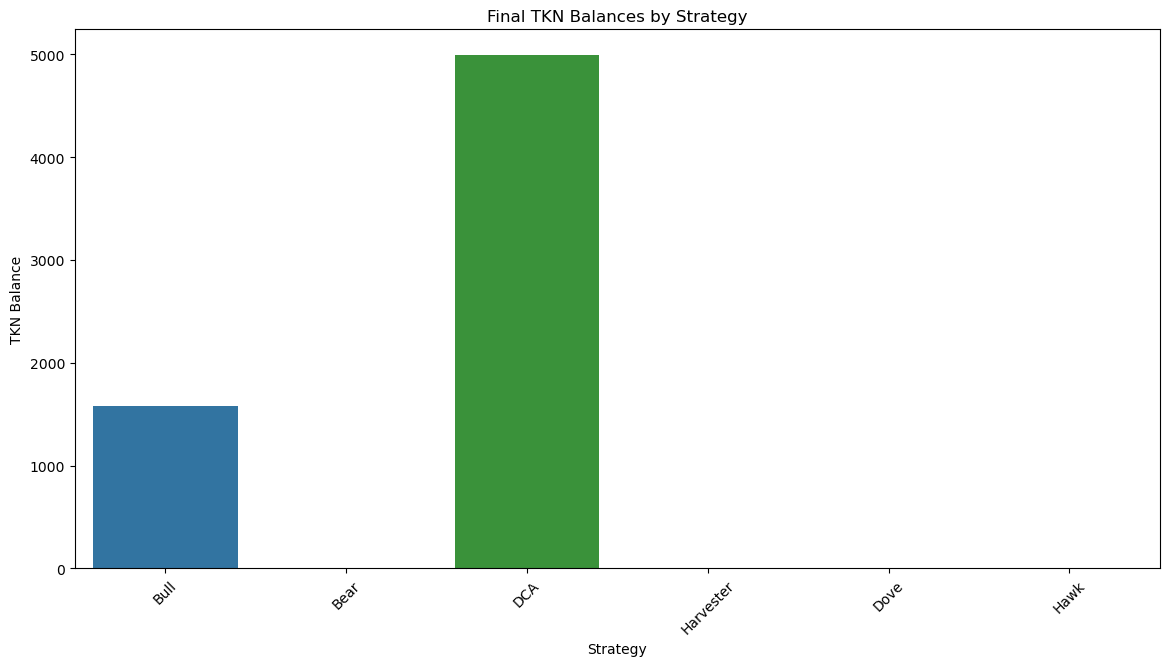

In [76]:
plot_final_tkn_balances_by_strategy(simulation_data['final_balances_table'])


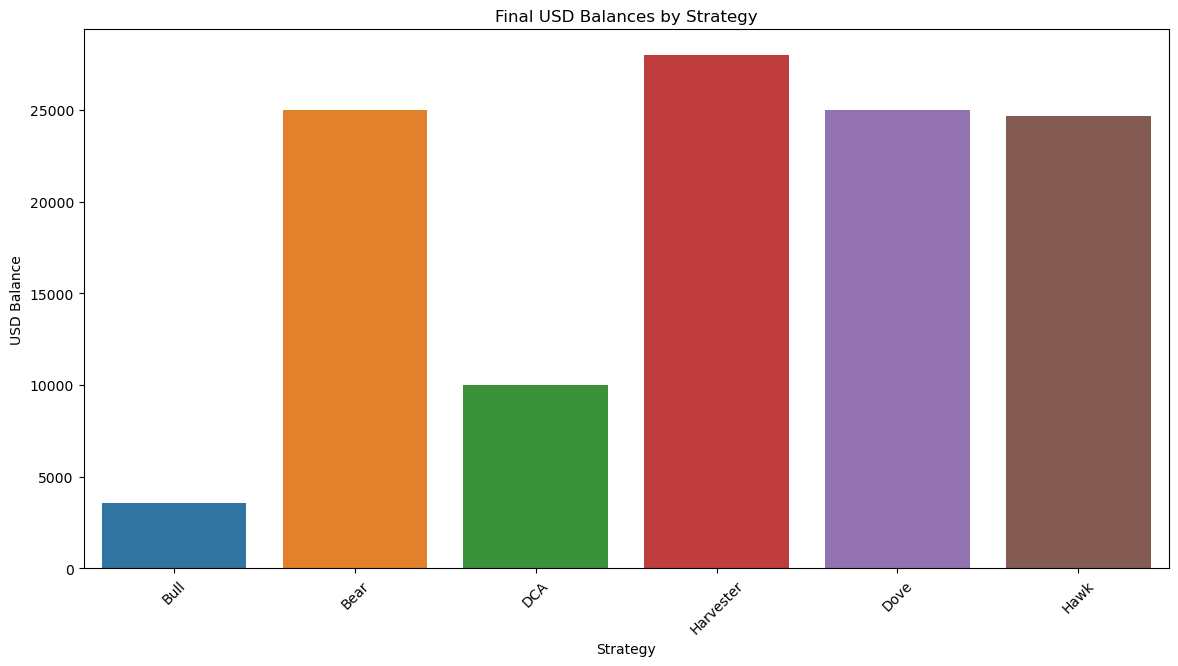

In [77]:
plot_final_usd_balances_by_strategy(simulation_data['final_balances_table'])


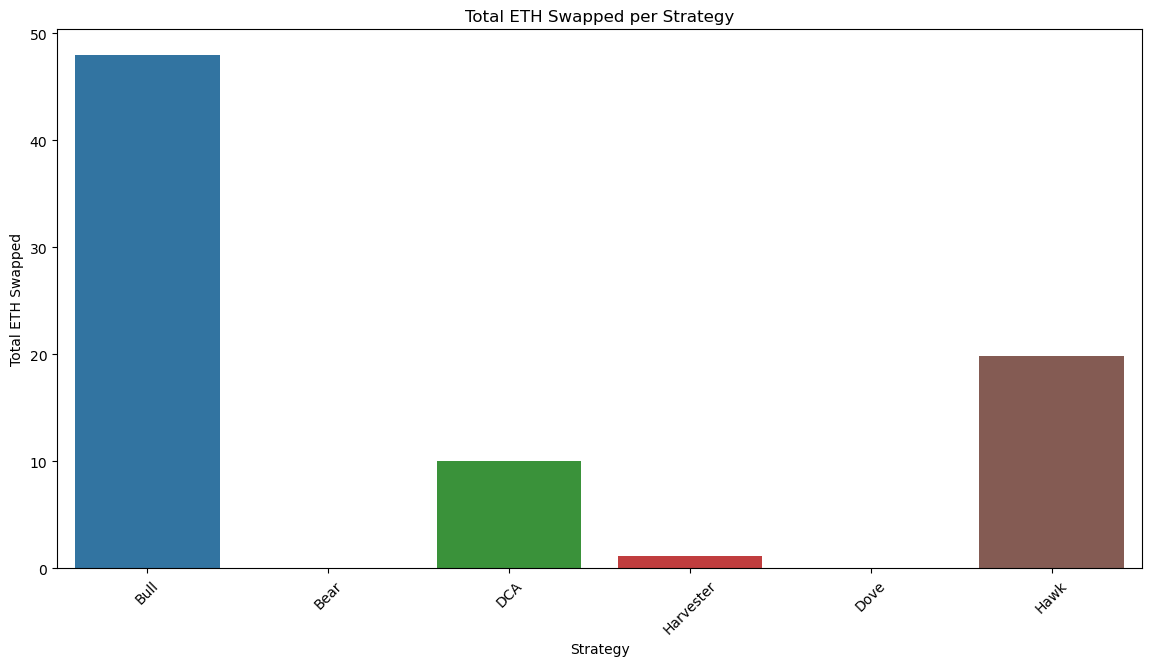

In [78]:
plot_total_eth_swapped_per_strategy(simulation_data['total_volume_swapped_table'])


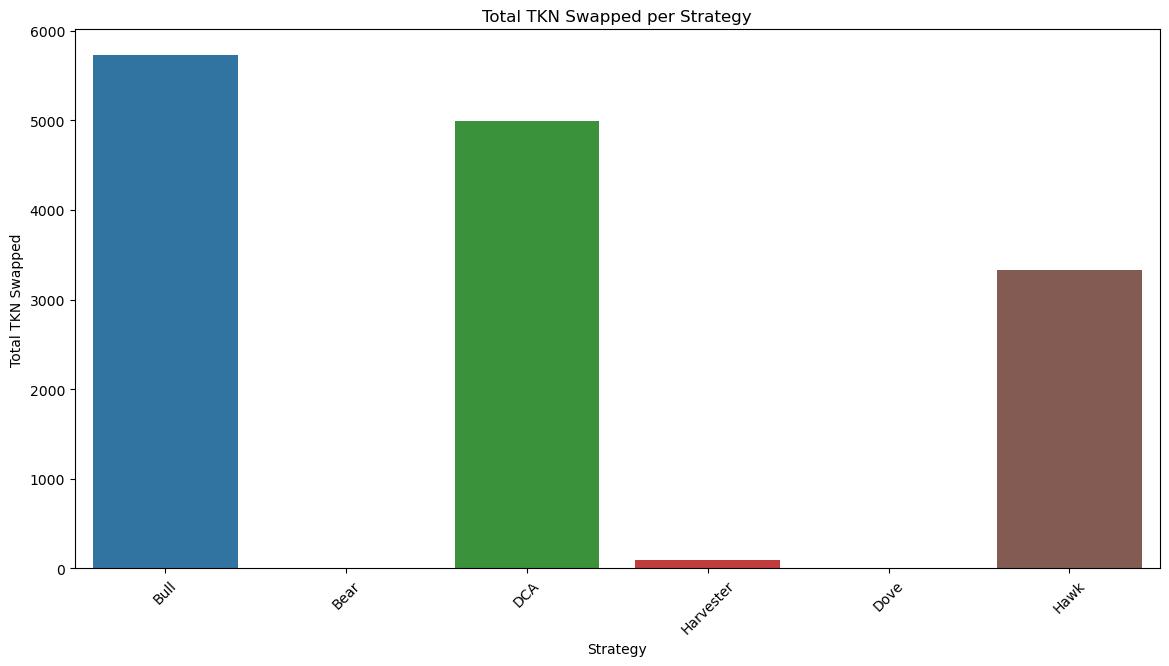

In [79]:
plot_total_tkn_swapped_per_strategy(simulation_data['total_volume_swapped_table'])


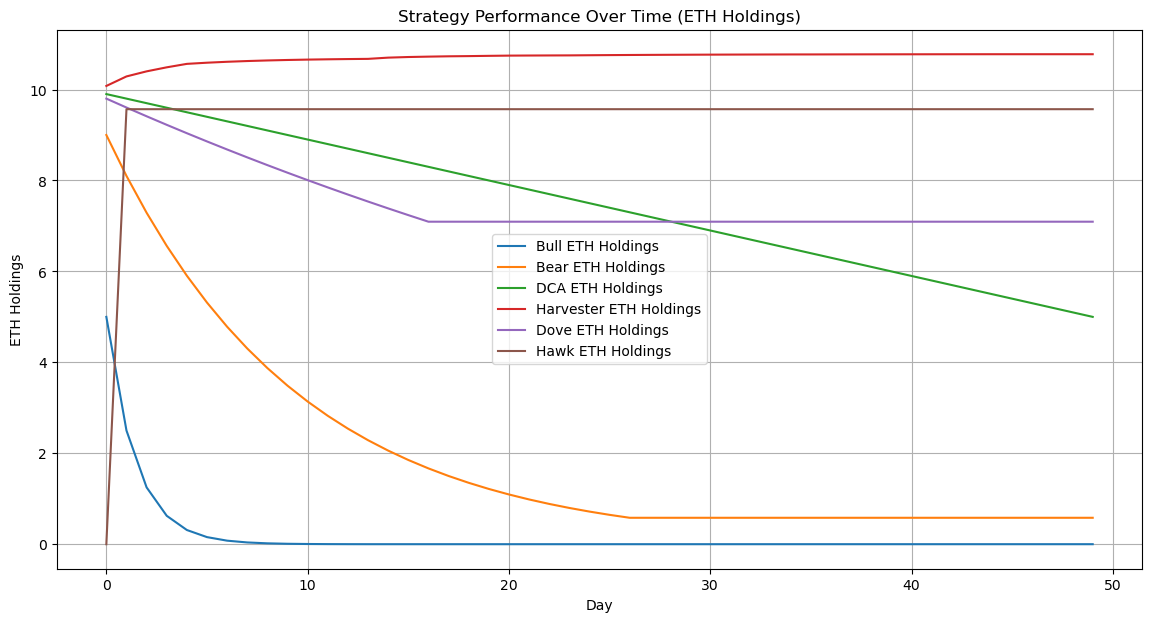

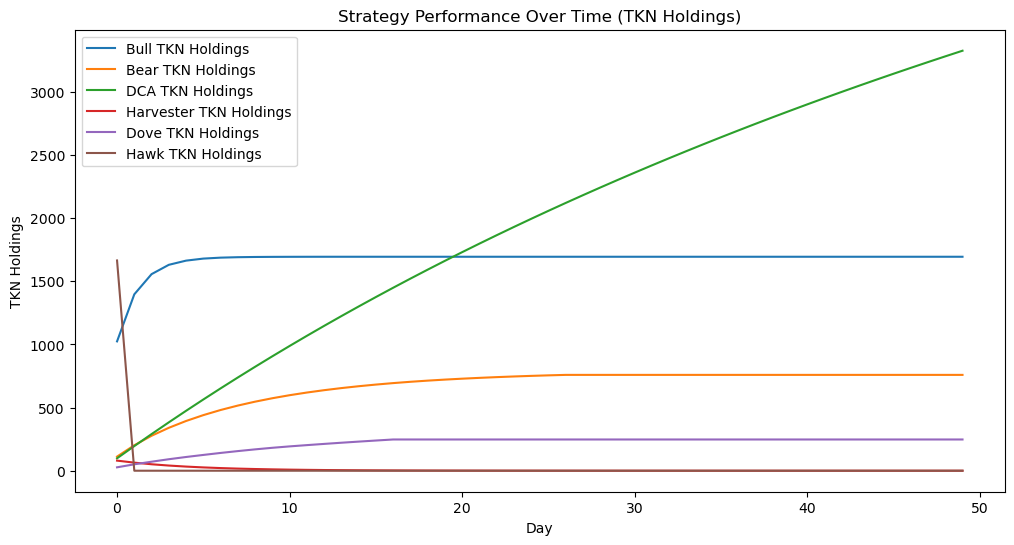

In [81]:
plot_strategy_performance_over_time(strategies, eth_price_history)


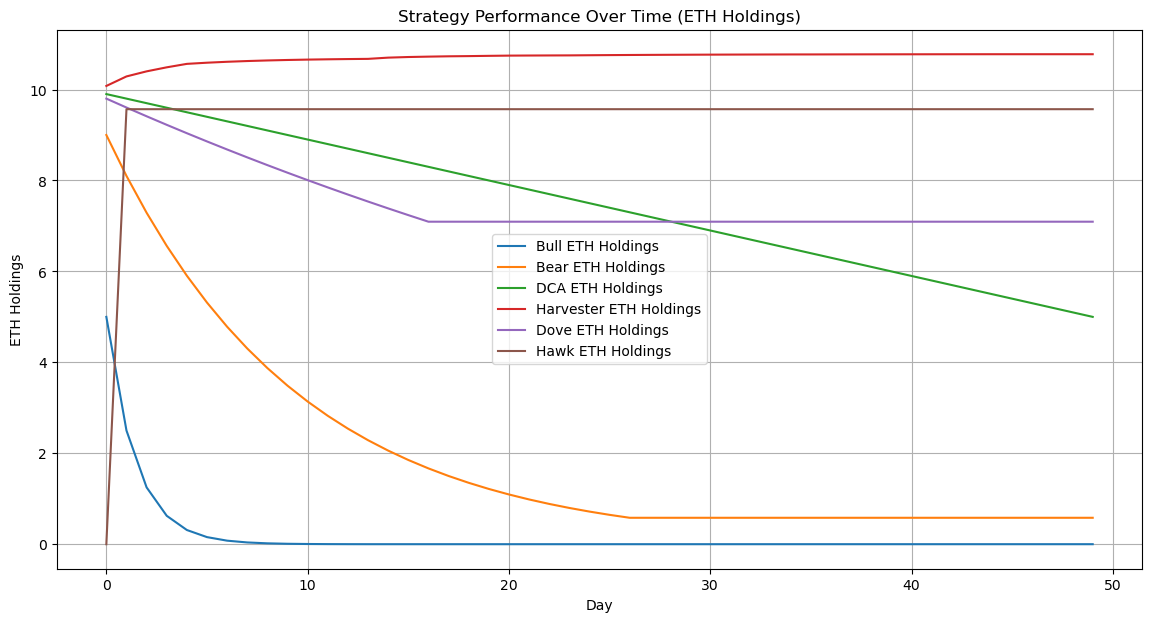

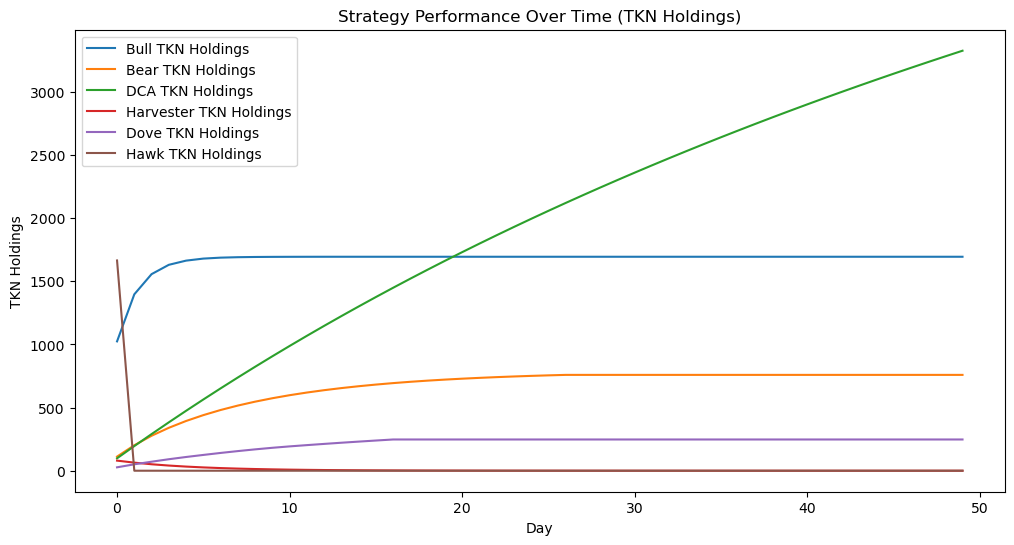

In [82]:
plot_strategy_performance_over_time(strategies, tkn_price_history)
